In [23]:
import model_wrapper as mw
import data_transformers as dt
from data_transformers import create_molecular_features, process_molecular_features
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import json
from paths import PIPELINES_DIR, MODELS_DIR
pd.set_option("display.max_columns", 100)
from auxiliary import plotScatterWithIdeal, get_logger

from functools import partial
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

from chembl_webresource_client.new_client import new_client

from enum import Enum
class ColumnNames(Enum):
    SMILES_COLUMN = "canonical_smiles"
    TARGET_COLUMN = "standard_value"

l = get_logger(logger_name="logger")

In [2]:
available_resources = [resource for resource in dir(new_client) if not resource.startswith('_')]
print(available_resources)

['activity', 'activity_supplementary_data_by_activity', 'assay', 'assay_class', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'drug', 'drug_indication', 'drug_warning', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_relation', 'tissue', 'xref_source']


In [3]:
from chembl_webresource_client.new_client import new_client

target = new_client.target
activity = new_client.activity
herg = target.filter(pref_name__iexact='hERG').only('target_chembl_id')[0]
herg_activities = activity.filter(target_chembl_id=herg['target_chembl_id']).filter(standard_type="IC50")
print(herg)
print(len(herg_activities))

{'target_chembl_id': 'CHEMBL240'}
13953


In [4]:
from chembl_webresource_client.new_client import new_client

target_client = new_client.target
gene_name = 'PXR'
res = target_client.filter(target_synonym__icontains=gene_name).only(['organism', 'pref_name', 'target_type', 'target_chembl_id'])
#target = target_client.filter(pref_name__iexact='gamma').only('target_chembl_id')[0]
#herg_activities = activity.filter(target_chembl_id=herg['target_chembl_id']).filter(standard_type="IC50")
for t in res:
    print(t)
print(res)

{'organism': 'Homo sapiens', 'pref_name': 'Pregnane X receptor', 'target_chembl_id': 'CHEMBL3401', 'target_type': 'SINGLE PROTEIN'}
{'organism': 'Mus musculus', 'pref_name': 'Nuclear receptor subfamily 1 group I member 2', 'target_chembl_id': 'CHEMBL1743244', 'target_type': 'SINGLE PROTEIN'}
{'organism': 'Rattus norvegicus', 'pref_name': 'Nuclear receptor subfamily 1 group I member 2', 'target_chembl_id': 'CHEMBL2146315', 'target_type': 'SINGLE PROTEIN'}
[{'organism': 'Homo sapiens', 'pref_name': 'Pregnane X receptor', 'target_chembl_id': 'CHEMBL3401', 'target_type': 'SINGLE PROTEIN'}, {'organism': 'Mus musculus', 'pref_name': 'Nuclear receptor subfamily 1 group I member 2', 'target_chembl_id': 'CHEMBL1743244', 'target_type': 'SINGLE PROTEIN'}, {'organism': 'Rattus norvegicus', 'pref_name': 'Nuclear receptor subfamily 1 group I member 2', 'target_chembl_id': 'CHEMBL2146315', 'target_type': 'SINGLE PROTEIN'}]


In [5]:
from chembl_webresource_client.new_client import new_client

target = new_client.target
activity = new_client.activity
res = activity.filter(target_chembl_id='CHEMBL3401').filter(standard_type="EC50")

In [6]:
keys = list(res[0].keys())
final_dict = dict()
for key in keys:
    final_dict[key] = list()

for idx, act in enumerate(res):
    for key in keys: final_dict[key].append(act[key])
final_df = pd.DataFrame(final_dict)

In [7]:
final_df.head()

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1679441,[],CHEMBL861915,Effect on PXR activity,B,None,None,BAO_0000188,BAO_0000357,single protein format,O=c1c(C2=Nc3ccccc3S(=O)(=O)N2)c(O)c2cc(F)ccc2n...,None,None,CHEMBL1148625,J. Med. Chem.,2006.0,"{'bei': '12.34', 'le': '0.24', 'lle': '2.26', ...",CHEMBL372357,None,CHEMBL372357,5.28,0,http://www.openphacts.org/units/Nanomolar,420133,=,1,1,=,None,EC50,nM,None,5300.0,CHEMBL3401,Homo sapiens,Pregnane X receptor,9606,None,None,EC50,uM,UO_0000065,None,5.3
1,None,1940895,[],CHEMBL891767,Antagonist activity at human PXR by transient ...,F,None,None,BAO_0000188,BAO_0000019,assay format,CCCC(O)(c1ccc(N(CC(F)(F)F)S(=O)(=O)c2ccccc2)cc...,None,None,CHEMBL1146359,Bioorg. Med. Chem.,2007.0,None,CHEMBL242528,None,CHEMBL242528,6.80,0,http://www.openphacts.org/units/Nanomolar,647671,=,1,1,=,None,EC50,nM,None,158.49,CHEMBL3401,Homo sapiens,Pregnane X receptor,9606,None,None,Log EC50,None,UO_0000065,None,-6.8
2,None,1940897,[],CHEMBL891767,Antagonist activity at human PXR by transient ...,F,None,None,BAO_0000188,BAO_0000019,assay format,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(CC(F)(...,None,None,CHEMBL1146359,Bioorg. Med. Chem.,2007.0,None,CHEMBL388024,None,CHEMBL388024,6.90,0,http://www.openphacts.org/units/Nanomolar,647670,=,1,1,=,None,EC50,nM,None,125.89,CHEMBL3401,Homo sapiens,Pregnane X receptor,9606,None,None,Log EC50,None,UO_0000065,None,-6.9
3,None,1940899,[],CHEMBL891767,Antagonist activity at human PXR by transient ...,F,None,None,BAO_0000188,BAO_0000019,assay format,CC(O)(c1ccc(N(CC(F)(F)F)S(=O)(=O)c2ccccc2)cc1)...,None,None,CHEMBL1146359,Bioorg. Med. Chem.,2007.0,None,CHEMBL242527,None,CHEMBL242527,6.30,0,http://www.openphacts.org/units/Nanomolar,647669,=,1,1,=,None,EC50,nM,None,501.19,CHEMBL3401,Homo sapiens,Pregnane X receptor,9606,None,None,Log EC50,None,UO_0000065,None,-6.3
4,None,1940901,[],CHEMBL891767,Antagonist activity at human PXR by transient ...,F,None,None,BAO_0000188,BAO_0000019,assay format,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)C(F)(F)...,None,None,CHEMBL1146359,Bioorg. Med. Chem.,2007.0,None,CHEMBL242526,None,CHEMBL242526,6.00,0,http://www.openphacts.org/units/Nanomolar,647668,=,1,1,=,None,EC50,nM,None,1000.0,CHEMBL3401,Homo sapiens,Pregnane X receptor,9606,None,None,Log EC50,None,UO_0000065,None,-6.0


In [8]:
final_df = final_df[~pd.isna(final_df["standard_value"])]
final_df["standard_value"] = final_df["standard_value"].astype(float)
final_df = final_df.groupby("molecule_chembl_id").agg({"standard_value": np.mean, "canonical_smiles": min})

In [9]:
smiles_codes = final_df[ColumnNames.SMILES_COLUMN.value].copy()
target = final_df[ColumnNames.TARGET_COLUMN.value].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_configuration = dt.read_in_pipeline(pipeline_file="QED_pipeline.json", 
                                                pipeline_directory=PIPELINES_DIR)

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

smiles_codes_train, smiles_codes_train_val, y_train, y_train_val = train_test_split(smiles_codes, y_train, test_size=0.1, random_state=42)

In [10]:
prediction_type = "regression"
model_wrapper = mw.model_wrapper.M_XGBoost(prediction_type=prediction_type, pipeline_configuration=pipeline_configuration)
model_wrapper.Data = {"smiles_codes_train": smiles_codes_train, "targets_train": y_train, "smiles_codes_val": smiles_codes_train_val, "targets_val": y_train_val}

2022-07-30 15:50:52,463 - logger - INFO - Scaler constructor...


In [11]:
model_wrapper.Create_Features()

2022-07-30 15:50:58,049 - logger - INFO - CreateFPS fit...
2022-07-30 15:50:58,050 - logger - INFO - CreateFPS transform...
100%|██████████| 719/719 [00:01<00:00, 527.37it/s]


In [13]:
with open(PIPELINES_DIR/"QED_training.json", "r") as f:
    training_conf = json.load(f)
configuration_train = training_conf["training_aux_data"]

In [14]:
fmin_objective = partial(model_wrapper.F_Opt, aux_data=configuration_train)
trials = Trials()
rstate = np.random.RandomState(42)
max_evals = configuration_train["max_evals"]
best_hyperparams = fmin(fn=fmin_objective, space=model_wrapper.Space, algo=tpe.suggest, max_evals=max_evals, 
                        trials=trials, return_argmin=True, rstate=rstate, show_progressbar=True)

  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

2022-07-30 15:53:00,768 - logger - INFO - Scaler fit...
2022-07-30 15:53:00,771 - logger - INFO - Scaler transform...
2022-07-30 15:53:00,774 - logger - INFO - Scaler transform...
2022-07-30 15:53:01,134 - logger - INFO - Scaler fit...
2022-07-30 15:53:01,136 - logger - INFO - Scaler transform...
2022-07-30 15:53:01,139 - logger - INFO - Scaler transform...
2022-07-30 15:53:01,319 - logger - INFO - Scaler fit...
2022-07-30 15:53:01,321 - logger - INFO - Scaler transform...
2022-07-30 15:53:01,324 - logger - INFO - Scaler transform...
2022-07-30 15:53:01,511 - logger - INFO - Scaler fit...
2022-07-30 15:53:01,513 - logger - INFO - Scaler transform...
2022-07-30 15:53:01,516 - logger - INFO - Scaler transform...


  0%|          | 1/200 [00:01<03:19,  1.00s/it, best loss: 0.5334010316369926]

2022-07-30 15:53:01,773 - logger - INFO - Scaler fit...
2022-07-30 15:53:01,775 - logger - INFO - Scaler transform...
2022-07-30 15:53:01,778 - logger - INFO - Scaler transform...
2022-07-30 15:53:02,035 - logger - INFO - Scaler fit...
2022-07-30 15:53:02,038 - logger - INFO - Scaler transform...
2022-07-30 15:53:02,041 - logger - INFO - Scaler transform...
2022-07-30 15:53:02,383 - logger - INFO - Scaler fit...
2022-07-30 15:53:02,385 - logger - INFO - Scaler transform...
2022-07-30 15:53:02,388 - logger - INFO - Scaler transform...
2022-07-30 15:53:02,505 - logger - INFO - Scaler fit...
2022-07-30 15:53:02,507 - logger - INFO - Scaler transform...
2022-07-30 15:53:02,510 - logger - INFO - Scaler transform...


  1%|          | 2/200 [00:01<03:02,  1.09it/s, best loss: 0.5334010316369926]

2022-07-30 15:53:02,634 - logger - INFO - Scaler fit...
2022-07-30 15:53:02,636 - logger - INFO - Scaler transform...
2022-07-30 15:53:02,638 - logger - INFO - Scaler transform...
2022-07-30 15:53:02,941 - logger - INFO - Scaler fit...
2022-07-30 15:53:02,943 - logger - INFO - Scaler transform...
2022-07-30 15:53:02,946 - logger - INFO - Scaler transform...
2022-07-30 15:53:03,143 - logger - INFO - Scaler fit...
2022-07-30 15:53:03,145 - logger - INFO - Scaler transform...
2022-07-30 15:53:03,148 - logger - INFO - Scaler transform...
2022-07-30 15:53:03,297 - logger - INFO - Scaler fit...
2022-07-30 15:53:03,299 - logger - INFO - Scaler transform...
2022-07-30 15:53:03,302 - logger - INFO - Scaler transform...


  2%|▏         | 3/200 [00:02<03:16,  1.00it/s, best loss: 0.5122205792892294]

2022-07-30 15:53:03,723 - logger - INFO - Scaler fit...
2022-07-30 15:53:03,725 - logger - INFO - Scaler transform...
2022-07-30 15:53:03,727 - logger - INFO - Scaler transform...
2022-07-30 15:53:04,103 - logger - INFO - Scaler fit...
2022-07-30 15:53:04,105 - logger - INFO - Scaler transform...
2022-07-30 15:53:04,108 - logger - INFO - Scaler transform...
2022-07-30 15:53:04,401 - logger - INFO - Scaler fit...
2022-07-30 15:53:04,403 - logger - INFO - Scaler transform...
2022-07-30 15:53:04,406 - logger - INFO - Scaler transform...
2022-07-30 15:53:04,770 - logger - INFO - Scaler fit...
2022-07-30 15:53:04,772 - logger - INFO - Scaler transform...
2022-07-30 15:53:04,776 - logger - INFO - Scaler transform...


  2%|▏         | 4/200 [00:04<03:38,  1.12s/it, best loss: 0.5122205792892294]

2022-07-30 15:53:05,019 - logger - INFO - Scaler fit...
2022-07-30 15:53:05,021 - logger - INFO - Scaler transform...
2022-07-30 15:53:05,024 - logger - INFO - Scaler transform...
2022-07-30 15:53:05,244 - logger - INFO - Scaler fit...
2022-07-30 15:53:05,246 - logger - INFO - Scaler transform...
2022-07-30 15:53:05,249 - logger - INFO - Scaler transform...
2022-07-30 15:53:05,404 - logger - INFO - Scaler fit...
2022-07-30 15:53:05,406 - logger - INFO - Scaler transform...
2022-07-30 15:53:05,408 - logger - INFO - Scaler transform...
2022-07-30 15:53:05,663 - logger - INFO - Scaler fit...
2022-07-30 15:53:05,665 - logger - INFO - Scaler transform...
2022-07-30 15:53:05,668 - logger - INFO - Scaler transform...


  2%|▎         | 5/200 [00:05<03:15,  1.00s/it, best loss: 0.5122205792892294]

2022-07-30 15:53:05,824 - logger - INFO - Scaler fit...
2022-07-30 15:53:05,826 - logger - INFO - Scaler transform...
2022-07-30 15:53:05,829 - logger - INFO - Scaler transform...
2022-07-30 15:53:06,238 - logger - INFO - Scaler fit...
2022-07-30 15:53:06,240 - logger - INFO - Scaler transform...
2022-07-30 15:53:06,243 - logger - INFO - Scaler transform...
2022-07-30 15:53:06,596 - logger - INFO - Scaler fit...
2022-07-30 15:53:06,598 - logger - INFO - Scaler transform...
2022-07-30 15:53:06,601 - logger - INFO - Scaler transform...
2022-07-30 15:53:06,863 - logger - INFO - Scaler fit...
2022-07-30 15:53:06,865 - logger - INFO - Scaler transform...
2022-07-30 15:53:06,868 - logger - INFO - Scaler transform...


  3%|▎         | 6/200 [00:06<03:32,  1.09s/it, best loss: 0.5122205792892294]

2022-07-30 15:53:07,091 - logger - INFO - Scaler fit...
2022-07-30 15:53:07,094 - logger - INFO - Scaler transform...
2022-07-30 15:53:07,097 - logger - INFO - Scaler transform...
2022-07-30 15:53:07,258 - logger - INFO - Scaler fit...
2022-07-30 15:53:07,260 - logger - INFO - Scaler transform...
2022-07-30 15:53:07,263 - logger - INFO - Scaler transform...
2022-07-30 15:53:07,654 - logger - INFO - Scaler fit...
2022-07-30 15:53:07,656 - logger - INFO - Scaler transform...
2022-07-30 15:53:07,660 - logger - INFO - Scaler transform...
2022-07-30 15:53:07,835 - logger - INFO - Scaler fit...
2022-07-30 15:53:07,838 - logger - INFO - Scaler transform...
2022-07-30 15:53:07,841 - logger - INFO - Scaler transform...


  4%|▎         | 7/200 [00:07<03:20,  1.04s/it, best loss: 0.5122205792892294]

2022-07-30 15:53:08,014 - logger - INFO - Scaler fit...
2022-07-30 15:53:08,017 - logger - INFO - Scaler transform...
2022-07-30 15:53:08,020 - logger - INFO - Scaler transform...
2022-07-30 15:53:08,533 - logger - INFO - Scaler fit...
2022-07-30 15:53:08,535 - logger - INFO - Scaler transform...
2022-07-30 15:53:08,538 - logger - INFO - Scaler transform...
2022-07-30 15:53:09,044 - logger - INFO - Scaler fit...
2022-07-30 15:53:09,047 - logger - INFO - Scaler transform...
2022-07-30 15:53:09,051 - logger - INFO - Scaler transform...
2022-07-30 15:53:09,291 - logger - INFO - Scaler fit...
2022-07-30 15:53:09,293 - logger - INFO - Scaler transform...
2022-07-30 15:53:09,296 - logger - INFO - Scaler transform...


  4%|▍         | 8/200 [00:08<03:49,  1.19s/it, best loss: 0.5122205792892294]

2022-07-30 15:53:09,539 - logger - INFO - Scaler fit...
2022-07-30 15:53:09,541 - logger - INFO - Scaler transform...
2022-07-30 15:53:09,544 - logger - INFO - Scaler transform...
2022-07-30 15:53:09,680 - logger - INFO - Scaler fit...
2022-07-30 15:53:09,682 - logger - INFO - Scaler transform...
2022-07-30 15:53:09,685 - logger - INFO - Scaler transform...
2022-07-30 15:53:09,836 - logger - INFO - Scaler fit...
2022-07-30 15:53:09,838 - logger - INFO - Scaler transform...
2022-07-30 15:53:09,841 - logger - INFO - Scaler transform...
2022-07-30 15:53:10,164 - logger - INFO - Scaler fit...
2022-07-30 15:53:10,166 - logger - INFO - Scaler transform...
2022-07-30 15:53:10,169 - logger - INFO - Scaler transform...


  4%|▍         | 9/200 [00:09<03:23,  1.07s/it, best loss: 0.5122205792892294]

2022-07-30 15:53:10,325 - logger - INFO - Scaler fit...
2022-07-30 15:53:10,327 - logger - INFO - Scaler transform...
2022-07-30 15:53:10,329 - logger - INFO - Scaler transform...
2022-07-30 15:53:10,444 - logger - INFO - Scaler fit...
2022-07-30 15:53:10,446 - logger - INFO - Scaler transform...
2022-07-30 15:53:10,449 - logger - INFO - Scaler transform...
2022-07-30 15:53:10,596 - logger - INFO - Scaler fit...
2022-07-30 15:53:10,599 - logger - INFO - Scaler transform...
2022-07-30 15:53:10,601 - logger - INFO - Scaler transform...
2022-07-30 15:53:10,837 - logger - INFO - Scaler fit...
2022-07-30 15:53:10,839 - logger - INFO - Scaler transform...
2022-07-30 15:53:10,842 - logger - INFO - Scaler transform...


  5%|▌         | 10/200 [00:10<03:00,  1.05it/s, best loss: 0.5122205792892294]

2022-07-30 15:53:11,012 - logger - INFO - Scaler fit...
2022-07-30 15:53:11,014 - logger - INFO - Scaler transform...
2022-07-30 15:53:11,016 - logger - INFO - Scaler transform...
2022-07-30 15:53:11,188 - logger - INFO - Scaler fit...
2022-07-30 15:53:11,190 - logger - INFO - Scaler transform...
2022-07-30 15:53:11,194 - logger - INFO - Scaler transform...
2022-07-30 15:53:11,229 - logger - INFO - Scaler fit...
2022-07-30 15:53:11,232 - logger - INFO - Scaler transform...
2022-07-30 15:53:11,235 - logger - INFO - Scaler transform...
2022-07-30 15:53:11,280 - logger - INFO - Scaler fit...
2022-07-30 15:53:11,282 - logger - INFO - Scaler transform...
2022-07-30 15:53:11,285 - logger - INFO - Scaler transform...


  6%|▌         | 11/200 [00:10<02:25,  1.30it/s, best loss: 0.5122205792892294]

2022-07-30 15:53:11,374 - logger - INFO - Scaler fit...
2022-07-30 15:53:11,376 - logger - INFO - Scaler transform...
2022-07-30 15:53:11,379 - logger - INFO - Scaler transform...
2022-07-30 15:53:11,904 - logger - INFO - Scaler fit...
2022-07-30 15:53:11,906 - logger - INFO - Scaler transform...
2022-07-30 15:53:11,910 - logger - INFO - Scaler transform...
2022-07-30 15:53:12,251 - logger - INFO - Scaler fit...
2022-07-30 15:53:12,253 - logger - INFO - Scaler transform...
2022-07-30 15:53:12,256 - logger - INFO - Scaler transform...
2022-07-30 15:53:12,555 - logger - INFO - Scaler fit...
2022-07-30 15:53:12,558 - logger - INFO - Scaler transform...
2022-07-30 15:53:12,560 - logger - INFO - Scaler transform...


  6%|▌         | 12/200 [00:12<03:11,  1.02s/it, best loss: 0.5122205792892294]

2022-07-30 15:53:12,966 - logger - INFO - Scaler fit...
2022-07-30 15:53:12,968 - logger - INFO - Scaler transform...
2022-07-30 15:53:12,971 - logger - INFO - Scaler transform...
2022-07-30 15:53:13,182 - logger - INFO - Scaler fit...
2022-07-30 15:53:13,184 - logger - INFO - Scaler transform...
2022-07-30 15:53:13,187 - logger - INFO - Scaler transform...
2022-07-30 15:53:13,596 - logger - INFO - Scaler fit...
2022-07-30 15:53:13,599 - logger - INFO - Scaler transform...
2022-07-30 15:53:13,602 - logger - INFO - Scaler transform...
2022-07-30 15:53:13,897 - logger - INFO - Scaler fit...
2022-07-30 15:53:13,899 - logger - INFO - Scaler transform...
2022-07-30 15:53:13,902 - logger - INFO - Scaler transform...


  6%|▋         | 13/200 [00:13<03:15,  1.05s/it, best loss: 0.5122205792892294]

2022-07-30 15:53:14,077 - logger - INFO - Scaler fit...
2022-07-30 15:53:14,079 - logger - INFO - Scaler transform...
2022-07-30 15:53:14,081 - logger - INFO - Scaler transform...
2022-07-30 15:53:14,266 - logger - INFO - Scaler fit...
2022-07-30 15:53:14,268 - logger - INFO - Scaler transform...
2022-07-30 15:53:14,271 - logger - INFO - Scaler transform...
2022-07-30 15:53:14,363 - logger - INFO - Scaler fit...
2022-07-30 15:53:14,366 - logger - INFO - Scaler transform...
2022-07-30 15:53:14,368 - logger - INFO - Scaler transform...
2022-07-30 15:53:14,723 - logger - INFO - Scaler fit...
2022-07-30 15:53:14,725 - logger - INFO - Scaler transform...
2022-07-30 15:53:14,728 - logger - INFO - Scaler transform...


  7%|▋         | 14/200 [00:14<02:58,  1.04it/s, best loss: 0.5122205792892294]

2022-07-30 15:53:14,838 - logger - INFO - Scaler fit...
2022-07-30 15:53:14,840 - logger - INFO - Scaler transform...
2022-07-30 15:53:14,843 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,029 - logger - INFO - Scaler fit...
2022-07-30 15:53:15,031 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,034 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,176 - logger - INFO - Scaler fit...
2022-07-30 15:53:15,178 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,182 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,308 - logger - INFO - Scaler fit...
2022-07-30 15:53:15,310 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,313 - logger - INFO - Scaler transform...


  8%|▊         | 15/200 [00:14<02:46,  1.11it/s, best loss: 0.5122205792892294]

2022-07-30 15:53:15,593 - logger - INFO - Scaler fit...
2022-07-30 15:53:15,595 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,598 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,671 - logger - INFO - Scaler fit...
2022-07-30 15:53:15,673 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,676 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,782 - logger - INFO - Scaler fit...
2022-07-30 15:53:15,784 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,787 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,992 - logger - INFO - Scaler fit...
2022-07-30 15:53:15,995 - logger - INFO - Scaler transform...
2022-07-30 15:53:15,998 - logger - INFO - Scaler transform...


  8%|▊         | 16/200 [00:15<02:26,  1.26it/s, best loss: 0.5122205792892294]

2022-07-30 15:53:16,146 - logger - INFO - Scaler fit...
2022-07-30 15:53:16,148 - logger - INFO - Scaler transform...
2022-07-30 15:53:16,151 - logger - INFO - Scaler transform...
2022-07-30 15:53:16,781 - logger - INFO - Scaler fit...
2022-07-30 15:53:16,784 - logger - INFO - Scaler transform...
2022-07-30 15:53:16,787 - logger - INFO - Scaler transform...
2022-07-30 15:53:17,216 - logger - INFO - Scaler fit...
2022-07-30 15:53:17,218 - logger - INFO - Scaler transform...
2022-07-30 15:53:17,221 - logger - INFO - Scaler transform...
2022-07-30 15:53:17,721 - logger - INFO - Scaler fit...
2022-07-30 15:53:17,723 - logger - INFO - Scaler transform...
2022-07-30 15:53:17,726 - logger - INFO - Scaler transform...


  8%|▊         | 17/200 [00:17<03:30,  1.15s/it, best loss: 0.5122205792892294]

2022-07-30 15:53:18,124 - logger - INFO - Scaler fit...
2022-07-30 15:53:18,127 - logger - INFO - Scaler transform...
2022-07-30 15:53:18,131 - logger - INFO - Scaler transform...
2022-07-30 15:53:18,349 - logger - INFO - Scaler fit...
2022-07-30 15:53:18,351 - logger - INFO - Scaler transform...
2022-07-30 15:53:18,354 - logger - INFO - Scaler transform...
2022-07-30 15:53:18,626 - logger - INFO - Scaler fit...
2022-07-30 15:53:18,629 - logger - INFO - Scaler transform...
2022-07-30 15:53:18,631 - logger - INFO - Scaler transform...
2022-07-30 15:53:18,987 - logger - INFO - Scaler fit...
2022-07-30 15:53:18,989 - logger - INFO - Scaler transform...
2022-07-30 15:53:18,992 - logger - INFO - Scaler transform...


  9%|▉         | 18/200 [00:18<03:27,  1.14s/it, best loss: 0.5122205792892294]

2022-07-30 15:53:19,235 - logger - INFO - Scaler fit...
2022-07-30 15:53:19,237 - logger - INFO - Scaler transform...
2022-07-30 15:53:19,240 - logger - INFO - Scaler transform...
2022-07-30 15:53:19,380 - logger - INFO - Scaler fit...
2022-07-30 15:53:19,382 - logger - INFO - Scaler transform...
2022-07-30 15:53:19,385 - logger - INFO - Scaler transform...
2022-07-30 15:53:19,491 - logger - INFO - Scaler fit...
2022-07-30 15:53:19,493 - logger - INFO - Scaler transform...
2022-07-30 15:53:19,496 - logger - INFO - Scaler transform...
2022-07-30 15:53:19,726 - logger - INFO - Scaler fit...
2022-07-30 15:53:19,728 - logger - INFO - Scaler transform...
2022-07-30 15:53:19,731 - logger - INFO - Scaler transform...


 10%|▉         | 19/200 [00:19<03:04,  1.02s/it, best loss: 0.5122205792892294]

2022-07-30 15:53:19,983 - logger - INFO - Scaler fit...
2022-07-30 15:53:19,985 - logger - INFO - Scaler transform...
2022-07-30 15:53:19,988 - logger - INFO - Scaler transform...
2022-07-30 15:53:20,124 - logger - INFO - Scaler fit...
2022-07-30 15:53:20,127 - logger - INFO - Scaler transform...
2022-07-30 15:53:20,129 - logger - INFO - Scaler transform...
2022-07-30 15:53:20,218 - logger - INFO - Scaler fit...
2022-07-30 15:53:20,220 - logger - INFO - Scaler transform...
2022-07-30 15:53:20,223 - logger - INFO - Scaler transform...
2022-07-30 15:53:20,336 - logger - INFO - Scaler fit...
2022-07-30 15:53:20,338 - logger - INFO - Scaler transform...
2022-07-30 15:53:20,341 - logger - INFO - Scaler transform...


 10%|█         | 20/200 [00:19<02:31,  1.19it/s, best loss: 0.5122205792892294]

2022-07-30 15:53:20,424 - logger - INFO - Scaler fit...
2022-07-30 15:53:20,426 - logger - INFO - Scaler transform...
2022-07-30 15:53:20,429 - logger - INFO - Scaler transform...
2022-07-30 15:53:20,783 - logger - INFO - Scaler fit...
2022-07-30 15:53:20,785 - logger - INFO - Scaler transform...
2022-07-30 15:53:20,788 - logger - INFO - Scaler transform...
2022-07-30 15:53:20,944 - logger - INFO - Scaler fit...
2022-07-30 15:53:20,946 - logger - INFO - Scaler transform...
2022-07-30 15:53:20,949 - logger - INFO - Scaler transform...
2022-07-30 15:53:21,154 - logger - INFO - Scaler fit...
2022-07-30 15:53:21,156 - logger - INFO - Scaler transform...
2022-07-30 15:53:21,159 - logger - INFO - Scaler transform...


 10%|█         | 21/200 [00:20<02:33,  1.17it/s, best loss: 0.5031316197566078]

2022-07-30 15:53:21,306 - logger - INFO - Scaler fit...
2022-07-30 15:53:21,308 - logger - INFO - Scaler transform...
2022-07-30 15:53:21,311 - logger - INFO - Scaler transform...
2022-07-30 15:53:21,600 - logger - INFO - Scaler fit...
2022-07-30 15:53:21,602 - logger - INFO - Scaler transform...
2022-07-30 15:53:21,605 - logger - INFO - Scaler transform...
2022-07-30 15:53:21,776 - logger - INFO - Scaler fit...
2022-07-30 15:53:21,778 - logger - INFO - Scaler transform...
2022-07-30 15:53:21,780 - logger - INFO - Scaler transform...
2022-07-30 15:53:21,985 - logger - INFO - Scaler fit...
2022-07-30 15:53:21,987 - logger - INFO - Scaler transform...
2022-07-30 15:53:21,990 - logger - INFO - Scaler transform...


 11%|█         | 22/200 [00:21<02:34,  1.16it/s, best loss: 0.5031316197566078]

2022-07-30 15:53:22,197 - logger - INFO - Scaler fit...
2022-07-30 15:53:22,199 - logger - INFO - Scaler transform...
2022-07-30 15:53:22,202 - logger - INFO - Scaler transform...
2022-07-30 15:53:22,586 - logger - INFO - Scaler fit...
2022-07-30 15:53:22,588 - logger - INFO - Scaler transform...
2022-07-30 15:53:22,591 - logger - INFO - Scaler transform...
2022-07-30 15:53:23,093 - logger - INFO - Scaler fit...
2022-07-30 15:53:23,095 - logger - INFO - Scaler transform...
2022-07-30 15:53:23,098 - logger - INFO - Scaler transform...
2022-07-30 15:53:23,462 - logger - INFO - Scaler fit...
2022-07-30 15:53:23,464 - logger - INFO - Scaler transform...
2022-07-30 15:53:23,467 - logger - INFO - Scaler transform...


 12%|█▏        | 23/200 [00:23<03:13,  1.10s/it, best loss: 0.5031316197566078]

2022-07-30 15:53:23,828 - logger - INFO - Scaler fit...
2022-07-30 15:53:23,830 - logger - INFO - Scaler transform...
2022-07-30 15:53:23,833 - logger - INFO - Scaler transform...
2022-07-30 15:53:23,956 - logger - INFO - Scaler fit...
2022-07-30 15:53:23,959 - logger - INFO - Scaler transform...
2022-07-30 15:53:23,962 - logger - INFO - Scaler transform...
2022-07-30 15:53:24,203 - logger - INFO - Scaler fit...
2022-07-30 15:53:24,205 - logger - INFO - Scaler transform...
2022-07-30 15:53:24,207 - logger - INFO - Scaler transform...
2022-07-30 15:53:24,412 - logger - INFO - Scaler fit...
2022-07-30 15:53:24,414 - logger - INFO - Scaler transform...
2022-07-30 15:53:24,416 - logger - INFO - Scaler transform...


 12%|█▏        | 24/200 [00:23<02:56,  1.00s/it, best loss: 0.5031316197566078]

2022-07-30 15:53:24,605 - logger - INFO - Scaler fit...
2022-07-30 15:53:24,607 - logger - INFO - Scaler transform...
2022-07-30 15:53:24,610 - logger - INFO - Scaler transform...
2022-07-30 15:53:25,002 - logger - INFO - Scaler fit...
2022-07-30 15:53:25,004 - logger - INFO - Scaler transform...
2022-07-30 15:53:25,010 - logger - INFO - Scaler transform...
2022-07-30 15:53:25,285 - logger - INFO - Scaler fit...
2022-07-30 15:53:25,288 - logger - INFO - Scaler transform...
2022-07-30 15:53:25,290 - logger - INFO - Scaler transform...
2022-07-30 15:53:25,527 - logger - INFO - Scaler fit...
2022-07-30 15:53:25,530 - logger - INFO - Scaler transform...
2022-07-30 15:53:25,533 - logger - INFO - Scaler transform...


 12%|█▎        | 25/200 [00:24<03:03,  1.05s/it, best loss: 0.4872396321623912]

2022-07-30 15:53:25,769 - logger - INFO - Scaler fit...
2022-07-30 15:53:25,771 - logger - INFO - Scaler transform...
2022-07-30 15:53:25,774 - logger - INFO - Scaler transform...
2022-07-30 15:53:26,236 - logger - INFO - Scaler fit...
2022-07-30 15:53:26,238 - logger - INFO - Scaler transform...
2022-07-30 15:53:26,241 - logger - INFO - Scaler transform...
2022-07-30 15:53:26,464 - logger - INFO - Scaler fit...
2022-07-30 15:53:26,467 - logger - INFO - Scaler transform...
2022-07-30 15:53:26,469 - logger - INFO - Scaler transform...
2022-07-30 15:53:26,700 - logger - INFO - Scaler fit...
2022-07-30 15:53:26,702 - logger - INFO - Scaler transform...
2022-07-30 15:53:26,705 - logger - INFO - Scaler transform...


 13%|█▎        | 26/200 [00:26<03:09,  1.09s/it, best loss: 0.4809855880292818]

2022-07-30 15:53:26,956 - logger - INFO - Scaler fit...
2022-07-30 15:53:26,957 - logger - INFO - Scaler transform...
2022-07-30 15:53:26,960 - logger - INFO - Scaler transform...
2022-07-30 15:53:27,345 - logger - INFO - Scaler fit...
2022-07-30 15:53:27,347 - logger - INFO - Scaler transform...
2022-07-30 15:53:27,351 - logger - INFO - Scaler transform...
2022-07-30 15:53:27,571 - logger - INFO - Scaler fit...
2022-07-30 15:53:27,573 - logger - INFO - Scaler transform...
2022-07-30 15:53:27,576 - logger - INFO - Scaler transform...
2022-07-30 15:53:27,915 - logger - INFO - Scaler fit...
2022-07-30 15:53:27,917 - logger - INFO - Scaler transform...
2022-07-30 15:53:27,919 - logger - INFO - Scaler transform...


 14%|█▎        | 27/200 [00:27<03:14,  1.12s/it, best loss: 0.4809855880292818]

2022-07-30 15:53:28,155 - logger - INFO - Scaler fit...
2022-07-30 15:53:28,157 - logger - INFO - Scaler transform...
2022-07-30 15:53:28,160 - logger - INFO - Scaler transform...
2022-07-30 15:53:28,545 - logger - INFO - Scaler fit...
2022-07-30 15:53:28,547 - logger - INFO - Scaler transform...
2022-07-30 15:53:28,550 - logger - INFO - Scaler transform...
2022-07-30 15:53:28,971 - logger - INFO - Scaler fit...
2022-07-30 15:53:28,974 - logger - INFO - Scaler transform...
2022-07-30 15:53:28,977 - logger - INFO - Scaler transform...
2022-07-30 15:53:29,434 - logger - INFO - Scaler fit...
2022-07-30 15:53:29,436 - logger - INFO - Scaler transform...
2022-07-30 15:53:29,439 - logger - INFO - Scaler transform...


 14%|█▍        | 28/200 [00:28<03:38,  1.27s/it, best loss: 0.4809855880292818]

2022-07-30 15:53:29,766 - logger - INFO - Scaler fit...
2022-07-30 15:53:29,768 - logger - INFO - Scaler transform...
2022-07-30 15:53:29,771 - logger - INFO - Scaler transform...
2022-07-30 15:53:30,030 - logger - INFO - Scaler fit...
2022-07-30 15:53:30,033 - logger - INFO - Scaler transform...
2022-07-30 15:53:30,036 - logger - INFO - Scaler transform...
2022-07-30 15:53:30,199 - logger - INFO - Scaler fit...
2022-07-30 15:53:30,201 - logger - INFO - Scaler transform...
2022-07-30 15:53:30,203 - logger - INFO - Scaler transform...
2022-07-30 15:53:30,431 - logger - INFO - Scaler fit...
2022-07-30 15:53:30,433 - logger - INFO - Scaler transform...
2022-07-30 15:53:30,436 - logger - INFO - Scaler transform...


 14%|█▍        | 29/200 [00:29<03:17,  1.15s/it, best loss: 0.4809855880292818]

2022-07-30 15:53:30,645 - logger - INFO - Scaler fit...
2022-07-30 15:53:30,647 - logger - INFO - Scaler transform...
2022-07-30 15:53:30,650 - logger - INFO - Scaler transform...
2022-07-30 15:53:30,899 - logger - INFO - Scaler fit...
2022-07-30 15:53:30,901 - logger - INFO - Scaler transform...
2022-07-30 15:53:30,905 - logger - INFO - Scaler transform...
2022-07-30 15:53:31,347 - logger - INFO - Scaler fit...
2022-07-30 15:53:31,349 - logger - INFO - Scaler transform...
2022-07-30 15:53:31,352 - logger - INFO - Scaler transform...
2022-07-30 15:53:31,643 - logger - INFO - Scaler fit...
2022-07-30 15:53:31,645 - logger - INFO - Scaler transform...
2022-07-30 15:53:31,648 - logger - INFO - Scaler transform...


 15%|█▌        | 30/200 [00:31<03:24,  1.20s/it, best loss: 0.4809855880292818]

2022-07-30 15:53:31,970 - logger - INFO - Scaler fit...
2022-07-30 15:53:31,973 - logger - INFO - Scaler transform...
2022-07-30 15:53:31,976 - logger - INFO - Scaler transform...
2022-07-30 15:53:32,402 - logger - INFO - Scaler fit...
2022-07-30 15:53:32,404 - logger - INFO - Scaler transform...
2022-07-30 15:53:32,407 - logger - INFO - Scaler transform...
2022-07-30 15:53:32,647 - logger - INFO - Scaler fit...
2022-07-30 15:53:32,649 - logger - INFO - Scaler transform...
2022-07-30 15:53:32,652 - logger - INFO - Scaler transform...
2022-07-30 15:53:32,914 - logger - INFO - Scaler fit...
2022-07-30 15:53:32,917 - logger - INFO - Scaler transform...
2022-07-30 15:53:32,920 - logger - INFO - Scaler transform...


 16%|█▌        | 31/200 [00:32<03:27,  1.23s/it, best loss: 0.480057605537715] 

2022-07-30 15:53:33,258 - logger - INFO - Scaler fit...
2022-07-30 15:53:33,261 - logger - INFO - Scaler transform...
2022-07-30 15:53:33,263 - logger - INFO - Scaler transform...
2022-07-30 15:53:33,620 - logger - INFO - Scaler fit...
2022-07-30 15:53:33,622 - logger - INFO - Scaler transform...
2022-07-30 15:53:33,625 - logger - INFO - Scaler transform...
2022-07-30 15:53:33,773 - logger - INFO - Scaler fit...
2022-07-30 15:53:33,775 - logger - INFO - Scaler transform...
2022-07-30 15:53:33,779 - logger - INFO - Scaler transform...
2022-07-30 15:53:34,153 - logger - INFO - Scaler fit...
2022-07-30 15:53:34,156 - logger - INFO - Scaler transform...
2022-07-30 15:53:34,159 - logger - INFO - Scaler transform...


 16%|█▌        | 32/200 [00:33<03:19,  1.19s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:34,346 - logger - INFO - Scaler fit...
2022-07-30 15:53:34,348 - logger - INFO - Scaler transform...
2022-07-30 15:53:34,351 - logger - INFO - Scaler transform...
2022-07-30 15:53:34,537 - logger - INFO - Scaler fit...
2022-07-30 15:53:34,539 - logger - INFO - Scaler transform...
2022-07-30 15:53:34,542 - logger - INFO - Scaler transform...
2022-07-30 15:53:34,889 - logger - INFO - Scaler fit...
2022-07-30 15:53:34,891 - logger - INFO - Scaler transform...
2022-07-30 15:53:34,894 - logger - INFO - Scaler transform...
2022-07-30 15:53:35,149 - logger - INFO - Scaler fit...
2022-07-30 15:53:35,151 - logger - INFO - Scaler transform...
2022-07-30 15:53:35,154 - logger - INFO - Scaler transform...


 16%|█▋        | 33/200 [00:34<03:09,  1.14s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:35,365 - logger - INFO - Scaler fit...
2022-07-30 15:53:35,367 - logger - INFO - Scaler transform...
2022-07-30 15:53:35,370 - logger - INFO - Scaler transform...
2022-07-30 15:53:35,711 - logger - INFO - Scaler fit...
2022-07-30 15:53:35,714 - logger - INFO - Scaler transform...
2022-07-30 15:53:35,717 - logger - INFO - Scaler transform...
2022-07-30 15:53:36,149 - logger - INFO - Scaler fit...
2022-07-30 15:53:36,151 - logger - INFO - Scaler transform...
2022-07-30 15:53:36,154 - logger - INFO - Scaler transform...
2022-07-30 15:53:36,388 - logger - INFO - Scaler fit...
2022-07-30 15:53:36,390 - logger - INFO - Scaler transform...
2022-07-30 15:53:36,393 - logger - INFO - Scaler transform...


 17%|█▋        | 34/200 [00:35<03:15,  1.18s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:36,640 - logger - INFO - Scaler fit...
2022-07-30 15:53:36,642 - logger - INFO - Scaler transform...
2022-07-30 15:53:36,645 - logger - INFO - Scaler transform...
2022-07-30 15:53:36,937 - logger - INFO - Scaler fit...
2022-07-30 15:53:36,939 - logger - INFO - Scaler transform...
2022-07-30 15:53:36,942 - logger - INFO - Scaler transform...
2022-07-30 15:53:37,265 - logger - INFO - Scaler fit...
2022-07-30 15:53:37,267 - logger - INFO - Scaler transform...
2022-07-30 15:53:37,270 - logger - INFO - Scaler transform...
2022-07-30 15:53:37,448 - logger - INFO - Scaler fit...
2022-07-30 15:53:37,450 - logger - INFO - Scaler transform...
2022-07-30 15:53:37,453 - logger - INFO - Scaler transform...


 18%|█▊        | 35/200 [00:36<03:10,  1.16s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:37,747 - logger - INFO - Scaler fit...
2022-07-30 15:53:37,749 - logger - INFO - Scaler transform...
2022-07-30 15:53:37,751 - logger - INFO - Scaler transform...
2022-07-30 15:53:38,011 - logger - INFO - Scaler fit...
2022-07-30 15:53:38,013 - logger - INFO - Scaler transform...
2022-07-30 15:53:38,016 - logger - INFO - Scaler transform...
2022-07-30 15:53:38,202 - logger - INFO - Scaler fit...
2022-07-30 15:53:38,205 - logger - INFO - Scaler transform...
2022-07-30 15:53:38,210 - logger - INFO - Scaler transform...
2022-07-30 15:53:38,446 - logger - INFO - Scaler fit...
2022-07-30 15:53:38,448 - logger - INFO - Scaler transform...
2022-07-30 15:53:38,451 - logger - INFO - Scaler transform...


 18%|█▊        | 36/200 [00:37<02:58,  1.09s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:38,680 - logger - INFO - Scaler fit...
2022-07-30 15:53:38,682 - logger - INFO - Scaler transform...
2022-07-30 15:53:38,685 - logger - INFO - Scaler transform...
2022-07-30 15:53:38,983 - logger - INFO - Scaler fit...
2022-07-30 15:53:38,985 - logger - INFO - Scaler transform...
2022-07-30 15:53:38,988 - logger - INFO - Scaler transform...
2022-07-30 15:53:39,133 - logger - INFO - Scaler fit...
2022-07-30 15:53:39,135 - logger - INFO - Scaler transform...
2022-07-30 15:53:39,138 - logger - INFO - Scaler transform...
2022-07-30 15:53:39,355 - logger - INFO - Scaler fit...
2022-07-30 15:53:39,357 - logger - INFO - Scaler transform...
2022-07-30 15:53:39,360 - logger - INFO - Scaler transform...


 18%|█▊        | 37/200 [00:38<02:52,  1.06s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:39,662 - logger - INFO - Scaler fit...
2022-07-30 15:53:39,664 - logger - INFO - Scaler transform...
2022-07-30 15:53:39,667 - logger - INFO - Scaler transform...
2022-07-30 15:53:39,852 - logger - INFO - Scaler fit...
2022-07-30 15:53:39,854 - logger - INFO - Scaler transform...
2022-07-30 15:53:39,856 - logger - INFO - Scaler transform...
2022-07-30 15:53:40,013 - logger - INFO - Scaler fit...
2022-07-30 15:53:40,015 - logger - INFO - Scaler transform...
2022-07-30 15:53:40,018 - logger - INFO - Scaler transform...
2022-07-30 15:53:40,342 - logger - INFO - Scaler fit...
2022-07-30 15:53:40,345 - logger - INFO - Scaler transform...
2022-07-30 15:53:40,347 - logger - INFO - Scaler transform...


 19%|█▉        | 38/200 [00:39<02:51,  1.06s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:40,723 - logger - INFO - Scaler fit...
2022-07-30 15:53:40,725 - logger - INFO - Scaler transform...
2022-07-30 15:53:40,728 - logger - INFO - Scaler transform...
2022-07-30 15:53:41,050 - logger - INFO - Scaler fit...
2022-07-30 15:53:41,052 - logger - INFO - Scaler transform...
2022-07-30 15:53:41,055 - logger - INFO - Scaler transform...
2022-07-30 15:53:41,240 - logger - INFO - Scaler fit...
2022-07-30 15:53:41,243 - logger - INFO - Scaler transform...
2022-07-30 15:53:41,247 - logger - INFO - Scaler transform...
2022-07-30 15:53:41,378 - logger - INFO - Scaler fit...
2022-07-30 15:53:41,380 - logger - INFO - Scaler transform...
2022-07-30 15:53:41,383 - logger - INFO - Scaler transform...


 20%|█▉        | 39/200 [00:40<02:46,  1.03s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:41,700 - logger - INFO - Scaler fit...
2022-07-30 15:53:41,702 - logger - INFO - Scaler transform...
2022-07-30 15:53:41,706 - logger - INFO - Scaler transform...
2022-07-30 15:53:42,030 - logger - INFO - Scaler fit...
2022-07-30 15:53:42,033 - logger - INFO - Scaler transform...
2022-07-30 15:53:42,036 - logger - INFO - Scaler transform...
2022-07-30 15:53:42,411 - logger - INFO - Scaler fit...
2022-07-30 15:53:42,413 - logger - INFO - Scaler transform...
2022-07-30 15:53:42,416 - logger - INFO - Scaler transform...
2022-07-30 15:53:42,830 - logger - INFO - Scaler fit...
2022-07-30 15:53:42,832 - logger - INFO - Scaler transform...
2022-07-30 15:53:42,835 - logger - INFO - Scaler transform...


 20%|██        | 40/200 [00:42<03:04,  1.15s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:43,133 - logger - INFO - Scaler fit...
2022-07-30 15:53:43,135 - logger - INFO - Scaler transform...
2022-07-30 15:53:43,138 - logger - INFO - Scaler transform...
2022-07-30 15:53:43,355 - logger - INFO - Scaler fit...
2022-07-30 15:53:43,357 - logger - INFO - Scaler transform...
2022-07-30 15:53:43,360 - logger - INFO - Scaler transform...
2022-07-30 15:53:43,589 - logger - INFO - Scaler fit...
2022-07-30 15:53:43,592 - logger - INFO - Scaler transform...
2022-07-30 15:53:43,596 - logger - INFO - Scaler transform...
2022-07-30 15:53:44,175 - logger - INFO - Scaler fit...
2022-07-30 15:53:44,177 - logger - INFO - Scaler transform...
2022-07-30 15:53:44,180 - logger - INFO - Scaler transform...


 20%|██        | 41/200 [00:43<03:06,  1.17s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:44,353 - logger - INFO - Scaler fit...
2022-07-30 15:53:44,356 - logger - INFO - Scaler transform...
2022-07-30 15:53:44,358 - logger - INFO - Scaler transform...
2022-07-30 15:53:44,559 - logger - INFO - Scaler fit...
2022-07-30 15:53:44,561 - logger - INFO - Scaler transform...
2022-07-30 15:53:44,564 - logger - INFO - Scaler transform...
2022-07-30 15:53:44,877 - logger - INFO - Scaler fit...
2022-07-30 15:53:44,879 - logger - INFO - Scaler transform...
2022-07-30 15:53:44,882 - logger - INFO - Scaler transform...
2022-07-30 15:53:45,013 - logger - INFO - Scaler fit...
2022-07-30 15:53:45,015 - logger - INFO - Scaler transform...
2022-07-30 15:53:45,018 - logger - INFO - Scaler transform...


 21%|██        | 42/200 [00:44<02:49,  1.07s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:45,195 - logger - INFO - Scaler fit...
2022-07-30 15:53:45,198 - logger - INFO - Scaler transform...
2022-07-30 15:53:45,200 - logger - INFO - Scaler transform...
2022-07-30 15:53:45,537 - logger - INFO - Scaler fit...
2022-07-30 15:53:45,539 - logger - INFO - Scaler transform...
2022-07-30 15:53:45,542 - logger - INFO - Scaler transform...
2022-07-30 15:53:45,726 - logger - INFO - Scaler fit...
2022-07-30 15:53:45,728 - logger - INFO - Scaler transform...
2022-07-30 15:53:45,731 - logger - INFO - Scaler transform...
2022-07-30 15:53:45,910 - logger - INFO - Scaler fit...
2022-07-30 15:53:45,912 - logger - INFO - Scaler transform...
2022-07-30 15:53:45,915 - logger - INFO - Scaler transform...


 22%|██▏       | 43/200 [00:45<02:39,  1.01s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:46,073 - logger - INFO - Scaler fit...
2022-07-30 15:53:46,076 - logger - INFO - Scaler transform...
2022-07-30 15:53:46,078 - logger - INFO - Scaler transform...
2022-07-30 15:53:46,450 - logger - INFO - Scaler fit...
2022-07-30 15:53:46,452 - logger - INFO - Scaler transform...
2022-07-30 15:53:46,454 - logger - INFO - Scaler transform...
2022-07-30 15:53:46,588 - logger - INFO - Scaler fit...
2022-07-30 15:53:46,590 - logger - INFO - Scaler transform...
2022-07-30 15:53:46,593 - logger - INFO - Scaler transform...
2022-07-30 15:53:46,760 - logger - INFO - Scaler fit...
2022-07-30 15:53:46,762 - logger - INFO - Scaler transform...
2022-07-30 15:53:46,765 - logger - INFO - Scaler transform...


 22%|██▏       | 44/200 [00:46<02:37,  1.01s/it, best loss: 0.4725433118955008]

2022-07-30 15:53:47,068 - logger - INFO - Scaler fit...
2022-07-30 15:53:47,072 - logger - INFO - Scaler transform...
2022-07-30 15:53:47,076 - logger - INFO - Scaler transform...
2022-07-30 15:53:47,348 - logger - INFO - Scaler fit...
2022-07-30 15:53:47,350 - logger - INFO - Scaler transform...
2022-07-30 15:53:47,353 - logger - INFO - Scaler transform...
2022-07-30 15:53:47,615 - logger - INFO - Scaler fit...
2022-07-30 15:53:47,617 - logger - INFO - Scaler transform...
2022-07-30 15:53:47,621 - logger - INFO - Scaler transform...
2022-07-30 15:53:47,825 - logger - INFO - Scaler fit...
2022-07-30 15:53:47,827 - logger - INFO - Scaler transform...
2022-07-30 15:53:47,830 - logger - INFO - Scaler transform...


 22%|██▎       | 45/200 [00:47<02:32,  1.02it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:47,983 - logger - INFO - Scaler fit...
2022-07-30 15:53:47,985 - logger - INFO - Scaler transform...
2022-07-30 15:53:47,988 - logger - INFO - Scaler transform...
2022-07-30 15:53:48,179 - logger - INFO - Scaler fit...
2022-07-30 15:53:48,181 - logger - INFO - Scaler transform...
2022-07-30 15:53:48,184 - logger - INFO - Scaler transform...
2022-07-30 15:53:48,498 - logger - INFO - Scaler fit...
2022-07-30 15:53:48,500 - logger - INFO - Scaler transform...
2022-07-30 15:53:48,503 - logger - INFO - Scaler transform...
2022-07-30 15:53:48,717 - logger - INFO - Scaler fit...
2022-07-30 15:53:48,719 - logger - INFO - Scaler transform...
2022-07-30 15:53:48,722 - logger - INFO - Scaler transform...


 23%|██▎       | 46/200 [00:48<02:33,  1.00it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:49,010 - logger - INFO - Scaler fit...
2022-07-30 15:53:49,012 - logger - INFO - Scaler transform...
2022-07-30 15:53:49,015 - logger - INFO - Scaler transform...
2022-07-30 15:53:49,231 - logger - INFO - Scaler fit...
2022-07-30 15:53:49,233 - logger - INFO - Scaler transform...
2022-07-30 15:53:49,236 - logger - INFO - Scaler transform...
2022-07-30 15:53:49,507 - logger - INFO - Scaler fit...
2022-07-30 15:53:49,509 - logger - INFO - Scaler transform...
2022-07-30 15:53:49,512 - logger - INFO - Scaler transform...
2022-07-30 15:53:49,709 - logger - INFO - Scaler fit...
2022-07-30 15:53:49,711 - logger - INFO - Scaler transform...
2022-07-30 15:53:49,715 - logger - INFO - Scaler transform...


 24%|██▎       | 47/200 [00:49<02:25,  1.05it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:49,868 - logger - INFO - Scaler fit...
2022-07-30 15:53:49,870 - logger - INFO - Scaler transform...
2022-07-30 15:53:49,873 - logger - INFO - Scaler transform...
2022-07-30 15:53:50,031 - logger - INFO - Scaler fit...
2022-07-30 15:53:50,033 - logger - INFO - Scaler transform...
2022-07-30 15:53:50,036 - logger - INFO - Scaler transform...
2022-07-30 15:53:50,455 - logger - INFO - Scaler fit...
2022-07-30 15:53:50,457 - logger - INFO - Scaler transform...
2022-07-30 15:53:50,460 - logger - INFO - Scaler transform...
2022-07-30 15:53:50,640 - logger - INFO - Scaler fit...
2022-07-30 15:53:50,642 - logger - INFO - Scaler transform...
2022-07-30 15:53:50,645 - logger - INFO - Scaler transform...


 24%|██▍       | 48/200 [00:50<02:25,  1.05it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:50,822 - logger - INFO - Scaler fit...
2022-07-30 15:53:50,824 - logger - INFO - Scaler transform...
2022-07-30 15:53:50,827 - logger - INFO - Scaler transform...
2022-07-30 15:53:50,938 - logger - INFO - Scaler fit...
2022-07-30 15:53:50,940 - logger - INFO - Scaler transform...
2022-07-30 15:53:50,943 - logger - INFO - Scaler transform...
2022-07-30 15:53:51,220 - logger - INFO - Scaler fit...
2022-07-30 15:53:51,222 - logger - INFO - Scaler transform...
2022-07-30 15:53:51,226 - logger - INFO - Scaler transform...
2022-07-30 15:53:51,361 - logger - INFO - Scaler fit...
2022-07-30 15:53:51,363 - logger - INFO - Scaler transform...
2022-07-30 15:53:51,366 - logger - INFO - Scaler transform...


 24%|██▍       | 49/200 [00:50<02:13,  1.13it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:51,550 - logger - INFO - Scaler fit...
2022-07-30 15:53:51,553 - logger - INFO - Scaler transform...
2022-07-30 15:53:51,556 - logger - INFO - Scaler transform...
2022-07-30 15:53:51,863 - logger - INFO - Scaler fit...
2022-07-30 15:53:51,865 - logger - INFO - Scaler transform...
2022-07-30 15:53:51,868 - logger - INFO - Scaler transform...
2022-07-30 15:53:51,986 - logger - INFO - Scaler fit...
2022-07-30 15:53:51,988 - logger - INFO - Scaler transform...
2022-07-30 15:53:51,991 - logger - INFO - Scaler transform...
2022-07-30 15:53:52,121 - logger - INFO - Scaler fit...
2022-07-30 15:53:52,123 - logger - INFO - Scaler transform...
2022-07-30 15:53:52,126 - logger - INFO - Scaler transform...


 25%|██▌       | 50/200 [00:51<02:08,  1.17it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:52,330 - logger - INFO - Scaler fit...
2022-07-30 15:53:52,332 - logger - INFO - Scaler transform...
2022-07-30 15:53:52,335 - logger - INFO - Scaler transform...
2022-07-30 15:53:52,653 - logger - INFO - Scaler fit...
2022-07-30 15:53:52,655 - logger - INFO - Scaler transform...
2022-07-30 15:53:52,658 - logger - INFO - Scaler transform...
2022-07-30 15:53:52,851 - logger - INFO - Scaler fit...
2022-07-30 15:53:52,853 - logger - INFO - Scaler transform...
2022-07-30 15:53:52,857 - logger - INFO - Scaler transform...
2022-07-30 15:53:53,005 - logger - INFO - Scaler fit...
2022-07-30 15:53:53,007 - logger - INFO - Scaler transform...
2022-07-30 15:53:53,010 - logger - INFO - Scaler transform...


 26%|██▌       | 51/200 [00:52<02:11,  1.14it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:53,269 - logger - INFO - Scaler fit...
2022-07-30 15:53:53,272 - logger - INFO - Scaler transform...
2022-07-30 15:53:53,274 - logger - INFO - Scaler transform...
2022-07-30 15:53:53,356 - logger - INFO - Scaler fit...
2022-07-30 15:53:53,358 - logger - INFO - Scaler transform...
2022-07-30 15:53:53,361 - logger - INFO - Scaler transform...
2022-07-30 15:53:53,631 - logger - INFO - Scaler fit...
2022-07-30 15:53:53,633 - logger - INFO - Scaler transform...
2022-07-30 15:53:53,636 - logger - INFO - Scaler transform...
2022-07-30 15:53:53,741 - logger - INFO - Scaler fit...
2022-07-30 15:53:53,743 - logger - INFO - Scaler transform...
2022-07-30 15:53:53,746 - logger - INFO - Scaler transform...


 26%|██▌       | 52/200 [00:53<01:57,  1.26it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:53,865 - logger - INFO - Scaler fit...
2022-07-30 15:53:53,867 - logger - INFO - Scaler transform...
2022-07-30 15:53:53,870 - logger - INFO - Scaler transform...
2022-07-30 15:53:54,213 - logger - INFO - Scaler fit...
2022-07-30 15:53:54,215 - logger - INFO - Scaler transform...
2022-07-30 15:53:54,218 - logger - INFO - Scaler transform...
2022-07-30 15:53:54,603 - logger - INFO - Scaler fit...
2022-07-30 15:53:54,606 - logger - INFO - Scaler transform...
2022-07-30 15:53:54,608 - logger - INFO - Scaler transform...
2022-07-30 15:53:54,930 - logger - INFO - Scaler fit...
2022-07-30 15:53:54,932 - logger - INFO - Scaler transform...
2022-07-30 15:53:54,934 - logger - INFO - Scaler transform...


 26%|██▋       | 53/200 [00:54<02:24,  1.02it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:55,279 - logger - INFO - Scaler fit...
2022-07-30 15:53:55,281 - logger - INFO - Scaler transform...
2022-07-30 15:53:55,284 - logger - INFO - Scaler transform...
2022-07-30 15:53:55,468 - logger - INFO - Scaler fit...
2022-07-30 15:53:55,470 - logger - INFO - Scaler transform...
2022-07-30 15:53:55,473 - logger - INFO - Scaler transform...
2022-07-30 15:53:55,615 - logger - INFO - Scaler fit...
2022-07-30 15:53:55,618 - logger - INFO - Scaler transform...
2022-07-30 15:53:55,621 - logger - INFO - Scaler transform...
2022-07-30 15:53:55,830 - logger - INFO - Scaler fit...
2022-07-30 15:53:55,832 - logger - INFO - Scaler transform...
2022-07-30 15:53:55,835 - logger - INFO - Scaler transform...


 27%|██▋       | 54/200 [00:55<02:19,  1.04it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:56,183 - logger - INFO - Scaler fit...
2022-07-30 15:53:56,185 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,187 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,249 - logger - INFO - Scaler fit...
2022-07-30 15:53:56,252 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,255 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,335 - logger - INFO - Scaler fit...
2022-07-30 15:53:56,337 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,340 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,533 - logger - INFO - Scaler fit...
2022-07-30 15:53:56,536 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,539 - logger - INFO - Scaler transform...


 28%|██▊       | 55/200 [00:55<02:02,  1.19it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:56,757 - logger - INFO - Scaler fit...
2022-07-30 15:53:56,759 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,762 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,825 - logger - INFO - Scaler fit...
2022-07-30 15:53:56,827 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,831 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,906 - logger - INFO - Scaler fit...
2022-07-30 15:53:56,908 - logger - INFO - Scaler transform...
2022-07-30 15:53:56,911 - logger - INFO - Scaler transform...
2022-07-30 15:53:57,137 - logger - INFO - Scaler fit...
2022-07-30 15:53:57,139 - logger - INFO - Scaler transform...
2022-07-30 15:53:57,142 - logger - INFO - Scaler transform...


 28%|██▊       | 56/200 [00:56<01:53,  1.27it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:57,421 - logger - INFO - Scaler fit...
2022-07-30 15:53:57,424 - logger - INFO - Scaler transform...
2022-07-30 15:53:57,428 - logger - INFO - Scaler transform...
2022-07-30 15:53:57,600 - logger - INFO - Scaler fit...
2022-07-30 15:53:57,603 - logger - INFO - Scaler transform...
2022-07-30 15:53:57,605 - logger - INFO - Scaler transform...
2022-07-30 15:53:57,926 - logger - INFO - Scaler fit...
2022-07-30 15:53:57,928 - logger - INFO - Scaler transform...
2022-07-30 15:53:57,931 - logger - INFO - Scaler transform...
2022-07-30 15:53:58,173 - logger - INFO - Scaler fit...
2022-07-30 15:53:58,175 - logger - INFO - Scaler transform...
2022-07-30 15:53:58,179 - logger - INFO - Scaler transform...


 28%|██▊       | 57/200 [00:57<01:56,  1.23it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:58,302 - logger - INFO - Scaler fit...
2022-07-30 15:53:58,304 - logger - INFO - Scaler transform...
2022-07-30 15:53:58,306 - logger - INFO - Scaler transform...
2022-07-30 15:53:58,550 - logger - INFO - Scaler fit...
2022-07-30 15:53:58,553 - logger - INFO - Scaler transform...
2022-07-30 15:53:58,556 - logger - INFO - Scaler transform...
2022-07-30 15:53:58,953 - logger - INFO - Scaler fit...
2022-07-30 15:53:58,955 - logger - INFO - Scaler transform...
2022-07-30 15:53:58,958 - logger - INFO - Scaler transform...
2022-07-30 15:53:59,191 - logger - INFO - Scaler fit...
2022-07-30 15:53:59,193 - logger - INFO - Scaler transform...
2022-07-30 15:53:59,196 - logger - INFO - Scaler transform...


 29%|██▉       | 58/200 [00:58<02:10,  1.08it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:59,469 - logger - INFO - Scaler fit...
2022-07-30 15:53:59,472 - logger - INFO - Scaler transform...
2022-07-30 15:53:59,475 - logger - INFO - Scaler transform...
2022-07-30 15:53:59,514 - logger - INFO - Scaler fit...
2022-07-30 15:53:59,516 - logger - INFO - Scaler transform...
2022-07-30 15:53:59,519 - logger - INFO - Scaler transform...
2022-07-30 15:53:59,773 - logger - INFO - Scaler fit...
2022-07-30 15:53:59,775 - logger - INFO - Scaler transform...
2022-07-30 15:53:59,779 - logger - INFO - Scaler transform...
2022-07-30 15:53:59,822 - logger - INFO - Scaler fit...
2022-07-30 15:53:59,824 - logger - INFO - Scaler transform...
2022-07-30 15:53:59,827 - logger - INFO - Scaler transform...


 30%|██▉       | 59/200 [00:59<01:48,  1.30it/s, best loss: 0.4725433118955008]

2022-07-30 15:53:59,889 - logger - INFO - Scaler fit...
2022-07-30 15:53:59,891 - logger - INFO - Scaler transform...
2022-07-30 15:53:59,894 - logger - INFO - Scaler transform...
2022-07-30 15:54:00,281 - logger - INFO - Scaler fit...
2022-07-30 15:54:00,283 - logger - INFO - Scaler transform...
2022-07-30 15:54:00,286 - logger - INFO - Scaler transform...
2022-07-30 15:54:00,602 - logger - INFO - Scaler fit...
2022-07-30 15:54:00,605 - logger - INFO - Scaler transform...
2022-07-30 15:54:00,607 - logger - INFO - Scaler transform...
2022-07-30 15:54:01,017 - logger - INFO - Scaler fit...
2022-07-30 15:54:01,020 - logger - INFO - Scaler transform...
2022-07-30 15:54:01,024 - logger - INFO - Scaler transform...


 30%|███       | 60/200 [01:00<02:19,  1.00it/s, best loss: 0.4725433118955008]

2022-07-30 15:54:01,415 - logger - INFO - Scaler fit...
2022-07-30 15:54:01,418 - logger - INFO - Scaler transform...
2022-07-30 15:54:01,421 - logger - INFO - Scaler transform...
2022-07-30 15:54:01,643 - logger - INFO - Scaler fit...
2022-07-30 15:54:01,645 - logger - INFO - Scaler transform...
2022-07-30 15:54:01,648 - logger - INFO - Scaler transform...
2022-07-30 15:54:01,899 - logger - INFO - Scaler fit...
2022-07-30 15:54:01,901 - logger - INFO - Scaler transform...
2022-07-30 15:54:01,904 - logger - INFO - Scaler transform...
2022-07-30 15:54:02,032 - logger - INFO - Scaler fit...
2022-07-30 15:54:02,034 - logger - INFO - Scaler transform...
2022-07-30 15:54:02,037 - logger - INFO - Scaler transform...


 30%|███       | 61/200 [01:01<02:08,  1.08it/s, best loss: 0.4725433118955008]

2022-07-30 15:54:02,176 - logger - INFO - Scaler fit...
2022-07-30 15:54:02,178 - logger - INFO - Scaler transform...
2022-07-30 15:54:02,181 - logger - INFO - Scaler transform...
2022-07-30 15:54:02,411 - logger - INFO - Scaler fit...
2022-07-30 15:54:02,413 - logger - INFO - Scaler transform...
2022-07-30 15:54:02,416 - logger - INFO - Scaler transform...
2022-07-30 15:54:02,733 - logger - INFO - Scaler fit...
2022-07-30 15:54:02,735 - logger - INFO - Scaler transform...
2022-07-30 15:54:02,738 - logger - INFO - Scaler transform...
2022-07-30 15:54:02,877 - logger - INFO - Scaler fit...
2022-07-30 15:54:02,879 - logger - INFO - Scaler transform...
2022-07-30 15:54:02,882 - logger - INFO - Scaler transform...


 31%|███       | 62/200 [01:02<02:10,  1.06it/s, best loss: 0.4725433118955008]

2022-07-30 15:54:03,157 - logger - INFO - Scaler fit...
2022-07-30 15:54:03,159 - logger - INFO - Scaler transform...
2022-07-30 15:54:03,163 - logger - INFO - Scaler transform...
2022-07-30 15:54:03,336 - logger - INFO - Scaler fit...
2022-07-30 15:54:03,339 - logger - INFO - Scaler transform...
2022-07-30 15:54:03,342 - logger - INFO - Scaler transform...
2022-07-30 15:54:03,634 - logger - INFO - Scaler fit...
2022-07-30 15:54:03,636 - logger - INFO - Scaler transform...
2022-07-30 15:54:03,639 - logger - INFO - Scaler transform...
2022-07-30 15:54:03,757 - logger - INFO - Scaler fit...
2022-07-30 15:54:03,759 - logger - INFO - Scaler transform...
2022-07-30 15:54:03,761 - logger - INFO - Scaler transform...


 32%|███▏      | 63/200 [01:03<02:04,  1.10it/s, best loss: 0.4725433118955008]

2022-07-30 15:54:03,976 - logger - INFO - Scaler fit...
2022-07-30 15:54:03,978 - logger - INFO - Scaler transform...
2022-07-30 15:54:03,981 - logger - INFO - Scaler transform...
2022-07-30 15:54:04,106 - logger - INFO - Scaler fit...
2022-07-30 15:54:04,108 - logger - INFO - Scaler transform...
2022-07-30 15:54:04,111 - logger - INFO - Scaler transform...
2022-07-30 15:54:04,440 - logger - INFO - Scaler fit...
2022-07-30 15:54:04,442 - logger - INFO - Scaler transform...
2022-07-30 15:54:04,445 - logger - INFO - Scaler transform...
2022-07-30 15:54:04,603 - logger - INFO - Scaler fit...
2022-07-30 15:54:04,605 - logger - INFO - Scaler transform...
2022-07-30 15:54:04,608 - logger - INFO - Scaler transform...


 32%|███▏      | 64/200 [01:04<02:02,  1.11it/s, best loss: 0.4725433118955008]

2022-07-30 15:54:04,863 - logger - INFO - Scaler fit...
2022-07-30 15:54:04,865 - logger - INFO - Scaler transform...
2022-07-30 15:54:04,868 - logger - INFO - Scaler transform...
2022-07-30 15:54:05,158 - logger - INFO - Scaler fit...
2022-07-30 15:54:05,160 - logger - INFO - Scaler transform...
2022-07-30 15:54:05,163 - logger - INFO - Scaler transform...
2022-07-30 15:54:05,267 - logger - INFO - Scaler fit...
2022-07-30 15:54:05,269 - logger - INFO - Scaler transform...
2022-07-30 15:54:05,272 - logger - INFO - Scaler transform...
2022-07-30 15:54:05,513 - logger - INFO - Scaler fit...
2022-07-30 15:54:05,516 - logger - INFO - Scaler transform...
2022-07-30 15:54:05,519 - logger - INFO - Scaler transform...


 32%|███▎      | 65/200 [01:04<01:56,  1.16it/s, best loss: 0.4725433118955008]

2022-07-30 15:54:05,642 - logger - INFO - Scaler fit...
2022-07-30 15:54:05,645 - logger - INFO - Scaler transform...
2022-07-30 15:54:05,647 - logger - INFO - Scaler transform...
2022-07-30 15:54:06,033 - logger - INFO - Scaler fit...
2022-07-30 15:54:06,036 - logger - INFO - Scaler transform...
2022-07-30 15:54:06,040 - logger - INFO - Scaler transform...
2022-07-30 15:54:06,195 - logger - INFO - Scaler fit...
2022-07-30 15:54:06,197 - logger - INFO - Scaler transform...
2022-07-30 15:54:06,200 - logger - INFO - Scaler transform...
2022-07-30 15:54:06,350 - logger - INFO - Scaler fit...
2022-07-30 15:54:06,352 - logger - INFO - Scaler transform...
2022-07-30 15:54:06,354 - logger - INFO - Scaler transform...


 33%|███▎      | 66/200 [01:05<01:56,  1.15it/s, best loss: 0.47194024045278804]

2022-07-30 15:54:06,523 - logger - INFO - Scaler fit...
2022-07-30 15:54:06,526 - logger - INFO - Scaler transform...
2022-07-30 15:54:06,531 - logger - INFO - Scaler transform...
2022-07-30 15:54:06,905 - logger - INFO - Scaler fit...
2022-07-30 15:54:06,908 - logger - INFO - Scaler transform...
2022-07-30 15:54:06,912 - logger - INFO - Scaler transform...
2022-07-30 15:54:07,189 - logger - INFO - Scaler fit...
2022-07-30 15:54:07,192 - logger - INFO - Scaler transform...
2022-07-30 15:54:07,195 - logger - INFO - Scaler transform...
2022-07-30 15:54:07,450 - logger - INFO - Scaler fit...
2022-07-30 15:54:07,452 - logger - INFO - Scaler transform...
2022-07-30 15:54:07,455 - logger - INFO - Scaler transform...


 34%|███▎      | 67/200 [01:06<02:10,  1.02it/s, best loss: 0.46659364418379373]

2022-07-30 15:54:07,775 - logger - INFO - Scaler fit...
2022-07-30 15:54:07,777 - logger - INFO - Scaler transform...
2022-07-30 15:54:07,780 - logger - INFO - Scaler transform...
2022-07-30 15:54:07,979 - logger - INFO - Scaler fit...
2022-07-30 15:54:07,981 - logger - INFO - Scaler transform...
2022-07-30 15:54:07,984 - logger - INFO - Scaler transform...
2022-07-30 15:54:08,154 - logger - INFO - Scaler fit...
2022-07-30 15:54:08,156 - logger - INFO - Scaler transform...
2022-07-30 15:54:08,159 - logger - INFO - Scaler transform...
2022-07-30 15:54:08,329 - logger - INFO - Scaler fit...
2022-07-30 15:54:08,332 - logger - INFO - Scaler transform...
2022-07-30 15:54:08,335 - logger - INFO - Scaler transform...


 34%|███▍      | 68/200 [01:07<02:09,  1.02it/s, best loss: 0.46659364418379373]

2022-07-30 15:54:08,760 - logger - INFO - Scaler fit...
2022-07-30 15:54:08,762 - logger - INFO - Scaler transform...
2022-07-30 15:54:08,764 - logger - INFO - Scaler transform...
2022-07-30 15:54:09,020 - logger - INFO - Scaler fit...
2022-07-30 15:54:09,022 - logger - INFO - Scaler transform...
2022-07-30 15:54:09,026 - logger - INFO - Scaler transform...
2022-07-30 15:54:09,198 - logger - INFO - Scaler fit...
2022-07-30 15:54:09,200 - logger - INFO - Scaler transform...
2022-07-30 15:54:09,202 - logger - INFO - Scaler transform...
2022-07-30 15:54:09,556 - logger - INFO - Scaler fit...
2022-07-30 15:54:09,558 - logger - INFO - Scaler transform...
2022-07-30 15:54:09,561 - logger - INFO - Scaler transform...


 34%|███▍      | 69/200 [01:09<02:14,  1.03s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:09,884 - logger - INFO - Scaler fit...
2022-07-30 15:54:09,886 - logger - INFO - Scaler transform...
2022-07-30 15:54:09,889 - logger - INFO - Scaler transform...
2022-07-30 15:54:10,183 - logger - INFO - Scaler fit...
2022-07-30 15:54:10,185 - logger - INFO - Scaler transform...
2022-07-30 15:54:10,188 - logger - INFO - Scaler transform...
2022-07-30 15:54:10,361 - logger - INFO - Scaler fit...
2022-07-30 15:54:10,363 - logger - INFO - Scaler transform...
2022-07-30 15:54:10,366 - logger - INFO - Scaler transform...
2022-07-30 15:54:10,727 - logger - INFO - Scaler fit...
2022-07-30 15:54:10,730 - logger - INFO - Scaler transform...
2022-07-30 15:54:10,732 - logger - INFO - Scaler transform...


 35%|███▌      | 70/200 [01:10<02:17,  1.06s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:11,005 - logger - INFO - Scaler fit...
2022-07-30 15:54:11,007 - logger - INFO - Scaler transform...
2022-07-30 15:54:11,009 - logger - INFO - Scaler transform...
2022-07-30 15:54:11,317 - logger - INFO - Scaler fit...
2022-07-30 15:54:11,320 - logger - INFO - Scaler transform...
2022-07-30 15:54:11,324 - logger - INFO - Scaler transform...
2022-07-30 15:54:11,606 - logger - INFO - Scaler fit...
2022-07-30 15:54:11,608 - logger - INFO - Scaler transform...
2022-07-30 15:54:11,611 - logger - INFO - Scaler transform...
2022-07-30 15:54:11,876 - logger - INFO - Scaler fit...
2022-07-30 15:54:11,878 - logger - INFO - Scaler transform...
2022-07-30 15:54:11,882 - logger - INFO - Scaler transform...


 36%|███▌      | 71/200 [01:11<02:16,  1.06s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:12,067 - logger - INFO - Scaler fit...
2022-07-30 15:54:12,069 - logger - INFO - Scaler transform...
2022-07-30 15:54:12,072 - logger - INFO - Scaler transform...
2022-07-30 15:54:12,496 - logger - INFO - Scaler fit...
2022-07-30 15:54:12,498 - logger - INFO - Scaler transform...
2022-07-30 15:54:12,501 - logger - INFO - Scaler transform...
2022-07-30 15:54:12,693 - logger - INFO - Scaler fit...
2022-07-30 15:54:12,695 - logger - INFO - Scaler transform...
2022-07-30 15:54:12,698 - logger - INFO - Scaler transform...
2022-07-30 15:54:12,955 - logger - INFO - Scaler fit...
2022-07-30 15:54:12,957 - logger - INFO - Scaler transform...
2022-07-30 15:54:12,960 - logger - INFO - Scaler transform...


 36%|███▌      | 72/200 [01:12<02:21,  1.11s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:13,285 - logger - INFO - Scaler fit...
2022-07-30 15:54:13,287 - logger - INFO - Scaler transform...
2022-07-30 15:54:13,290 - logger - INFO - Scaler transform...
2022-07-30 15:54:13,533 - logger - INFO - Scaler fit...
2022-07-30 15:54:13,535 - logger - INFO - Scaler transform...
2022-07-30 15:54:13,538 - logger - INFO - Scaler transform...
2022-07-30 15:54:13,712 - logger - INFO - Scaler fit...
2022-07-30 15:54:13,714 - logger - INFO - Scaler transform...
2022-07-30 15:54:13,717 - logger - INFO - Scaler transform...
2022-07-30 15:54:14,154 - logger - INFO - Scaler fit...
2022-07-30 15:54:14,156 - logger - INFO - Scaler transform...
2022-07-30 15:54:14,159 - logger - INFO - Scaler transform...


 36%|███▋      | 73/200 [01:13<02:19,  1.10s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:14,357 - logger - INFO - Scaler fit...
2022-07-30 15:54:14,359 - logger - INFO - Scaler transform...
2022-07-30 15:54:14,362 - logger - INFO - Scaler transform...
2022-07-30 15:54:14,546 - logger - INFO - Scaler fit...
2022-07-30 15:54:14,548 - logger - INFO - Scaler transform...
2022-07-30 15:54:14,551 - logger - INFO - Scaler transform...
2022-07-30 15:54:14,893 - logger - INFO - Scaler fit...
2022-07-30 15:54:14,895 - logger - INFO - Scaler transform...
2022-07-30 15:54:14,898 - logger - INFO - Scaler transform...
2022-07-30 15:54:15,095 - logger - INFO - Scaler fit...
2022-07-30 15:54:15,097 - logger - INFO - Scaler transform...
2022-07-30 15:54:15,100 - logger - INFO - Scaler transform...


 37%|███▋      | 74/200 [01:14<02:12,  1.05s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:15,306 - logger - INFO - Scaler fit...
2022-07-30 15:54:15,309 - logger - INFO - Scaler transform...
2022-07-30 15:54:15,314 - logger - INFO - Scaler transform...
2022-07-30 15:54:15,663 - logger - INFO - Scaler fit...
2022-07-30 15:54:15,666 - logger - INFO - Scaler transform...
2022-07-30 15:54:15,669 - logger - INFO - Scaler transform...
2022-07-30 15:54:15,874 - logger - INFO - Scaler fit...
2022-07-30 15:54:15,876 - logger - INFO - Scaler transform...
2022-07-30 15:54:15,879 - logger - INFO - Scaler transform...
2022-07-30 15:54:16,194 - logger - INFO - Scaler fit...
2022-07-30 15:54:16,197 - logger - INFO - Scaler transform...
2022-07-30 15:54:16,200 - logger - INFO - Scaler transform...


 38%|███▊      | 75/200 [01:15<02:15,  1.09s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:16,473 - logger - INFO - Scaler fit...
2022-07-30 15:54:16,476 - logger - INFO - Scaler transform...
2022-07-30 15:54:16,479 - logger - INFO - Scaler transform...
2022-07-30 15:54:16,859 - logger - INFO - Scaler fit...
2022-07-30 15:54:16,861 - logger - INFO - Scaler transform...
2022-07-30 15:54:16,864 - logger - INFO - Scaler transform...
2022-07-30 15:54:17,014 - logger - INFO - Scaler fit...
2022-07-30 15:54:17,016 - logger - INFO - Scaler transform...
2022-07-30 15:54:17,019 - logger - INFO - Scaler transform...
2022-07-30 15:54:17,169 - logger - INFO - Scaler fit...
2022-07-30 15:54:17,171 - logger - INFO - Scaler transform...
2022-07-30 15:54:17,173 - logger - INFO - Scaler transform...


 38%|███▊      | 76/200 [01:16<02:09,  1.04s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:17,415 - logger - INFO - Scaler fit...
2022-07-30 15:54:17,418 - logger - INFO - Scaler transform...
2022-07-30 15:54:17,421 - logger - INFO - Scaler transform...
2022-07-30 15:54:17,825 - logger - INFO - Scaler fit...
2022-07-30 15:54:17,827 - logger - INFO - Scaler transform...
2022-07-30 15:54:17,830 - logger - INFO - Scaler transform...
2022-07-30 15:54:17,987 - logger - INFO - Scaler fit...
2022-07-30 15:54:17,989 - logger - INFO - Scaler transform...
2022-07-30 15:54:17,992 - logger - INFO - Scaler transform...
2022-07-30 15:54:18,198 - logger - INFO - Scaler fit...
2022-07-30 15:54:18,200 - logger - INFO - Scaler transform...
2022-07-30 15:54:18,203 - logger - INFO - Scaler transform...


 38%|███▊      | 77/200 [01:17<02:11,  1.07s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:18,545 - logger - INFO - Scaler fit...
2022-07-30 15:54:18,547 - logger - INFO - Scaler transform...
2022-07-30 15:54:18,550 - logger - INFO - Scaler transform...
2022-07-30 15:54:18,848 - logger - INFO - Scaler fit...
2022-07-30 15:54:18,850 - logger - INFO - Scaler transform...
2022-07-30 15:54:18,853 - logger - INFO - Scaler transform...
2022-07-30 15:54:19,221 - logger - INFO - Scaler fit...
2022-07-30 15:54:19,223 - logger - INFO - Scaler transform...
2022-07-30 15:54:19,226 - logger - INFO - Scaler transform...
2022-07-30 15:54:19,602 - logger - INFO - Scaler fit...
2022-07-30 15:54:19,604 - logger - INFO - Scaler transform...
2022-07-30 15:54:19,607 - logger - INFO - Scaler transform...


 39%|███▉      | 78/200 [01:19<02:24,  1.19s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:20,003 - logger - INFO - Scaler fit...
2022-07-30 15:54:20,006 - logger - INFO - Scaler transform...
2022-07-30 15:54:20,008 - logger - INFO - Scaler transform...
2022-07-30 15:54:20,272 - logger - INFO - Scaler fit...
2022-07-30 15:54:20,275 - logger - INFO - Scaler transform...
2022-07-30 15:54:20,278 - logger - INFO - Scaler transform...
2022-07-30 15:54:20,484 - logger - INFO - Scaler fit...
2022-07-30 15:54:20,486 - logger - INFO - Scaler transform...
2022-07-30 15:54:20,489 - logger - INFO - Scaler transform...
2022-07-30 15:54:20,894 - logger - INFO - Scaler fit...
2022-07-30 15:54:20,896 - logger - INFO - Scaler transform...
2022-07-30 15:54:20,899 - logger - INFO - Scaler transform...


 40%|███▉      | 79/200 [01:20<02:25,  1.20s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:21,242 - logger - INFO - Scaler fit...
2022-07-30 15:54:21,244 - logger - INFO - Scaler transform...
2022-07-30 15:54:21,247 - logger - INFO - Scaler transform...
2022-07-30 15:54:21,461 - logger - INFO - Scaler fit...
2022-07-30 15:54:21,463 - logger - INFO - Scaler transform...
2022-07-30 15:54:21,466 - logger - INFO - Scaler transform...
2022-07-30 15:54:21,798 - logger - INFO - Scaler fit...
2022-07-30 15:54:21,800 - logger - INFO - Scaler transform...
2022-07-30 15:54:21,803 - logger - INFO - Scaler transform...
2022-07-30 15:54:22,046 - logger - INFO - Scaler fit...
2022-07-30 15:54:22,048 - logger - INFO - Scaler transform...
2022-07-30 15:54:22,052 - logger - INFO - Scaler transform...


 40%|████      | 80/200 [01:21<02:18,  1.16s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:22,295 - logger - INFO - Scaler fit...
2022-07-30 15:54:22,297 - logger - INFO - Scaler transform...
2022-07-30 15:54:22,300 - logger - INFO - Scaler transform...
2022-07-30 15:54:22,530 - logger - INFO - Scaler fit...
2022-07-30 15:54:22,532 - logger - INFO - Scaler transform...
2022-07-30 15:54:22,535 - logger - INFO - Scaler transform...
2022-07-30 15:54:22,890 - logger - INFO - Scaler fit...
2022-07-30 15:54:22,892 - logger - INFO - Scaler transform...
2022-07-30 15:54:22,895 - logger - INFO - Scaler transform...
2022-07-30 15:54:23,045 - logger - INFO - Scaler fit...
2022-07-30 15:54:23,047 - logger - INFO - Scaler transform...
2022-07-30 15:54:23,050 - logger - INFO - Scaler transform...


 40%|████      | 81/200 [01:22<02:09,  1.09s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:23,222 - logger - INFO - Scaler fit...
2022-07-30 15:54:23,224 - logger - INFO - Scaler transform...
2022-07-30 15:54:23,227 - logger - INFO - Scaler transform...
2022-07-30 15:54:23,421 - logger - INFO - Scaler fit...
2022-07-30 15:54:23,423 - logger - INFO - Scaler transform...
2022-07-30 15:54:23,425 - logger - INFO - Scaler transform...
2022-07-30 15:54:23,831 - logger - INFO - Scaler fit...
2022-07-30 15:54:23,833 - logger - INFO - Scaler transform...
2022-07-30 15:54:23,836 - logger - INFO - Scaler transform...
2022-07-30 15:54:24,028 - logger - INFO - Scaler fit...
2022-07-30 15:54:24,030 - logger - INFO - Scaler transform...
2022-07-30 15:54:24,033 - logger - INFO - Scaler transform...


 41%|████      | 82/200 [01:23<02:05,  1.06s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:24,224 - logger - INFO - Scaler fit...
2022-07-30 15:54:24,226 - logger - INFO - Scaler transform...
2022-07-30 15:54:24,229 - logger - INFO - Scaler transform...
2022-07-30 15:54:24,596 - logger - INFO - Scaler fit...
2022-07-30 15:54:24,599 - logger - INFO - Scaler transform...
2022-07-30 15:54:24,602 - logger - INFO - Scaler transform...
2022-07-30 15:54:24,858 - logger - INFO - Scaler fit...
2022-07-30 15:54:24,860 - logger - INFO - Scaler transform...
2022-07-30 15:54:24,863 - logger - INFO - Scaler transform...
2022-07-30 15:54:25,052 - logger - INFO - Scaler fit...
2022-07-30 15:54:25,054 - logger - INFO - Scaler transform...
2022-07-30 15:54:25,058 - logger - INFO - Scaler transform...


 42%|████▏     | 83/200 [01:24<02:09,  1.11s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:25,430 - logger - INFO - Scaler fit...
2022-07-30 15:54:25,432 - logger - INFO - Scaler transform...
2022-07-30 15:54:25,435 - logger - INFO - Scaler transform...
2022-07-30 15:54:25,782 - logger - INFO - Scaler fit...
2022-07-30 15:54:25,785 - logger - INFO - Scaler transform...
2022-07-30 15:54:25,787 - logger - INFO - Scaler transform...
2022-07-30 15:54:26,173 - logger - INFO - Scaler fit...
2022-07-30 15:54:26,175 - logger - INFO - Scaler transform...
2022-07-30 15:54:26,178 - logger - INFO - Scaler transform...
2022-07-30 15:54:26,585 - logger - INFO - Scaler fit...
2022-07-30 15:54:26,587 - logger - INFO - Scaler transform...
2022-07-30 15:54:26,590 - logger - INFO - Scaler transform...


 42%|████▏     | 84/200 [01:26<02:21,  1.22s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:26,906 - logger - INFO - Scaler fit...
2022-07-30 15:54:26,909 - logger - INFO - Scaler transform...
2022-07-30 15:54:26,911 - logger - INFO - Scaler transform...
2022-07-30 15:54:27,146 - logger - INFO - Scaler fit...
2022-07-30 15:54:27,148 - logger - INFO - Scaler transform...
2022-07-30 15:54:27,151 - logger - INFO - Scaler transform...
2022-07-30 15:54:27,329 - logger - INFO - Scaler fit...
2022-07-30 15:54:27,331 - logger - INFO - Scaler transform...
2022-07-30 15:54:27,334 - logger - INFO - Scaler transform...
2022-07-30 15:54:27,769 - logger - INFO - Scaler fit...
2022-07-30 15:54:27,771 - logger - INFO - Scaler transform...
2022-07-30 15:54:27,773 - logger - INFO - Scaler transform...


 42%|████▎     | 85/200 [01:27<02:15,  1.18s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:27,992 - logger - INFO - Scaler fit...
2022-07-30 15:54:27,994 - logger - INFO - Scaler transform...
2022-07-30 15:54:27,997 - logger - INFO - Scaler transform...
2022-07-30 15:54:28,289 - logger - INFO - Scaler fit...
2022-07-30 15:54:28,291 - logger - INFO - Scaler transform...
2022-07-30 15:54:28,294 - logger - INFO - Scaler transform...
2022-07-30 15:54:28,749 - logger - INFO - Scaler fit...
2022-07-30 15:54:28,752 - logger - INFO - Scaler transform...
2022-07-30 15:54:28,754 - logger - INFO - Scaler transform...
2022-07-30 15:54:28,992 - logger - INFO - Scaler fit...
2022-07-30 15:54:28,994 - logger - INFO - Scaler transform...
2022-07-30 15:54:28,997 - logger - INFO - Scaler transform...


 43%|████▎     | 86/200 [01:28<02:16,  1.19s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:29,229 - logger - INFO - Scaler fit...
2022-07-30 15:54:29,232 - logger - INFO - Scaler transform...
2022-07-30 15:54:29,235 - logger - INFO - Scaler transform...
2022-07-30 15:54:29,630 - logger - INFO - Scaler fit...
2022-07-30 15:54:29,632 - logger - INFO - Scaler transform...
2022-07-30 15:54:29,635 - logger - INFO - Scaler transform...
2022-07-30 15:54:29,969 - logger - INFO - Scaler fit...
2022-07-30 15:54:29,971 - logger - INFO - Scaler transform...
2022-07-30 15:54:29,974 - logger - INFO - Scaler transform...
2022-07-30 15:54:30,227 - logger - INFO - Scaler fit...
2022-07-30 15:54:30,229 - logger - INFO - Scaler transform...
2022-07-30 15:54:30,232 - logger - INFO - Scaler transform...


 44%|████▎     | 87/200 [01:29<02:23,  1.27s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:30,673 - logger - INFO - Scaler fit...
2022-07-30 15:54:30,675 - logger - INFO - Scaler transform...
2022-07-30 15:54:30,678 - logger - INFO - Scaler transform...
2022-07-30 15:54:30,902 - logger - INFO - Scaler fit...
2022-07-30 15:54:30,905 - logger - INFO - Scaler transform...
2022-07-30 15:54:30,908 - logger - INFO - Scaler transform...
2022-07-30 15:54:31,155 - logger - INFO - Scaler fit...
2022-07-30 15:54:31,157 - logger - INFO - Scaler transform...
2022-07-30 15:54:31,160 - logger - INFO - Scaler transform...
2022-07-30 15:54:31,536 - logger - INFO - Scaler fit...
2022-07-30 15:54:31,539 - logger - INFO - Scaler transform...
2022-07-30 15:54:31,541 - logger - INFO - Scaler transform...


 44%|████▍     | 88/200 [01:30<02:15,  1.21s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:31,744 - logger - INFO - Scaler fit...
2022-07-30 15:54:31,746 - logger - INFO - Scaler transform...
2022-07-30 15:54:31,749 - logger - INFO - Scaler transform...
2022-07-30 15:54:31,968 - logger - INFO - Scaler fit...
2022-07-30 15:54:31,970 - logger - INFO - Scaler transform...
2022-07-30 15:54:31,973 - logger - INFO - Scaler transform...
2022-07-30 15:54:32,397 - logger - INFO - Scaler fit...
2022-07-30 15:54:32,400 - logger - INFO - Scaler transform...
2022-07-30 15:54:32,403 - logger - INFO - Scaler transform...
2022-07-30 15:54:32,617 - logger - INFO - Scaler fit...
2022-07-30 15:54:32,619 - logger - INFO - Scaler transform...
2022-07-30 15:54:32,622 - logger - INFO - Scaler transform...


 44%|████▍     | 89/200 [01:32<02:12,  1.20s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:32,913 - logger - INFO - Scaler fit...
2022-07-30 15:54:32,915 - logger - INFO - Scaler transform...
2022-07-30 15:54:32,918 - logger - INFO - Scaler transform...
2022-07-30 15:54:33,221 - logger - INFO - Scaler fit...
2022-07-30 15:54:33,223 - logger - INFO - Scaler transform...
2022-07-30 15:54:33,226 - logger - INFO - Scaler transform...
2022-07-30 15:54:33,639 - logger - INFO - Scaler fit...
2022-07-30 15:54:33,641 - logger - INFO - Scaler transform...
2022-07-30 15:54:33,644 - logger - INFO - Scaler transform...
2022-07-30 15:54:33,852 - logger - INFO - Scaler fit...
2022-07-30 15:54:33,854 - logger - INFO - Scaler transform...
2022-07-30 15:54:33,857 - logger - INFO - Scaler transform...


 45%|████▌     | 90/200 [01:33<02:11,  1.19s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:34,099 - logger - INFO - Scaler fit...
2022-07-30 15:54:34,101 - logger - INFO - Scaler transform...
2022-07-30 15:54:34,104 - logger - INFO - Scaler transform...
2022-07-30 15:54:34,392 - logger - INFO - Scaler fit...
2022-07-30 15:54:34,394 - logger - INFO - Scaler transform...
2022-07-30 15:54:34,397 - logger - INFO - Scaler transform...
2022-07-30 15:54:34,769 - logger - INFO - Scaler fit...
2022-07-30 15:54:34,771 - logger - INFO - Scaler transform...
2022-07-30 15:54:34,774 - logger - INFO - Scaler transform...
2022-07-30 15:54:34,953 - logger - INFO - Scaler fit...
2022-07-30 15:54:34,955 - logger - INFO - Scaler transform...
2022-07-30 15:54:34,958 - logger - INFO - Scaler transform...


 46%|████▌     | 91/200 [01:34<02:05,  1.15s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:35,148 - logger - INFO - Scaler fit...
2022-07-30 15:54:35,150 - logger - INFO - Scaler transform...
2022-07-30 15:54:35,153 - logger - INFO - Scaler transform...
2022-07-30 15:54:35,494 - logger - INFO - Scaler fit...
2022-07-30 15:54:35,497 - logger - INFO - Scaler transform...
2022-07-30 15:54:35,500 - logger - INFO - Scaler transform...
2022-07-30 15:54:35,848 - logger - INFO - Scaler fit...
2022-07-30 15:54:35,850 - logger - INFO - Scaler transform...
2022-07-30 15:54:35,853 - logger - INFO - Scaler transform...
2022-07-30 15:54:36,091 - logger - INFO - Scaler fit...
2022-07-30 15:54:36,093 - logger - INFO - Scaler transform...
2022-07-30 15:54:36,096 - logger - INFO - Scaler transform...


 46%|████▌     | 92/200 [01:35<02:06,  1.17s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:36,363 - logger - INFO - Scaler fit...
2022-07-30 15:54:36,365 - logger - INFO - Scaler transform...
2022-07-30 15:54:36,368 - logger - INFO - Scaler transform...
2022-07-30 15:54:36,816 - logger - INFO - Scaler fit...
2022-07-30 15:54:36,818 - logger - INFO - Scaler transform...
2022-07-30 15:54:36,821 - logger - INFO - Scaler transform...
2022-07-30 15:54:37,081 - logger - INFO - Scaler fit...
2022-07-30 15:54:37,083 - logger - INFO - Scaler transform...
2022-07-30 15:54:37,086 - logger - INFO - Scaler transform...
2022-07-30 15:54:37,361 - logger - INFO - Scaler fit...
2022-07-30 15:54:37,364 - logger - INFO - Scaler transform...
2022-07-30 15:54:37,367 - logger - INFO - Scaler transform...


 46%|████▋     | 93/200 [01:36<02:10,  1.22s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:37,702 - logger - INFO - Scaler fit...
2022-07-30 15:54:37,704 - logger - INFO - Scaler transform...
2022-07-30 15:54:37,707 - logger - INFO - Scaler transform...
2022-07-30 15:54:38,093 - logger - INFO - Scaler fit...
2022-07-30 15:54:38,095 - logger - INFO - Scaler transform...
2022-07-30 15:54:38,098 - logger - INFO - Scaler transform...
2022-07-30 15:54:38,271 - logger - INFO - Scaler fit...
2022-07-30 15:54:38,274 - logger - INFO - Scaler transform...
2022-07-30 15:54:38,277 - logger - INFO - Scaler transform...
2022-07-30 15:54:38,382 - logger - INFO - Scaler fit...
2022-07-30 15:54:38,384 - logger - INFO - Scaler transform...
2022-07-30 15:54:38,386 - logger - INFO - Scaler transform...


 47%|████▋     | 94/200 [01:38<02:08,  1.22s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:38,909 - logger - INFO - Scaler fit...
2022-07-30 15:54:38,911 - logger - INFO - Scaler transform...
2022-07-30 15:54:38,914 - logger - INFO - Scaler transform...
2022-07-30 15:54:39,274 - logger - INFO - Scaler fit...
2022-07-30 15:54:39,276 - logger - INFO - Scaler transform...
2022-07-30 15:54:39,279 - logger - INFO - Scaler transform...
2022-07-30 15:54:39,545 - logger - INFO - Scaler fit...
2022-07-30 15:54:39,547 - logger - INFO - Scaler transform...
2022-07-30 15:54:39,550 - logger - INFO - Scaler transform...
2022-07-30 15:54:39,949 - logger - INFO - Scaler fit...
2022-07-30 15:54:39,951 - logger - INFO - Scaler transform...
2022-07-30 15:54:39,954 - logger - INFO - Scaler transform...


 48%|████▊     | 95/200 [01:39<02:10,  1.24s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:40,213 - logger - INFO - Scaler fit...
2022-07-30 15:54:40,215 - logger - INFO - Scaler transform...
2022-07-30 15:54:40,218 - logger - INFO - Scaler transform...
2022-07-30 15:54:40,479 - logger - INFO - Scaler fit...
2022-07-30 15:54:40,481 - logger - INFO - Scaler transform...
2022-07-30 15:54:40,484 - logger - INFO - Scaler transform...
2022-07-30 15:54:40,785 - logger - INFO - Scaler fit...
2022-07-30 15:54:40,787 - logger - INFO - Scaler transform...
2022-07-30 15:54:40,790 - logger - INFO - Scaler transform...
2022-07-30 15:54:40,917 - logger - INFO - Scaler fit...
2022-07-30 15:54:40,919 - logger - INFO - Scaler transform...
2022-07-30 15:54:40,922 - logger - INFO - Scaler transform...


 48%|████▊     | 96/200 [01:40<02:01,  1.17s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:41,204 - logger - INFO - Scaler fit...
2022-07-30 15:54:41,206 - logger - INFO - Scaler transform...
2022-07-30 15:54:41,209 - logger - INFO - Scaler transform...
2022-07-30 15:54:41,804 - logger - INFO - Scaler fit...
2022-07-30 15:54:41,806 - logger - INFO - Scaler transform...
2022-07-30 15:54:41,808 - logger - INFO - Scaler transform...
2022-07-30 15:54:42,204 - logger - INFO - Scaler fit...
2022-07-30 15:54:42,206 - logger - INFO - Scaler transform...
2022-07-30 15:54:42,209 - logger - INFO - Scaler transform...
2022-07-30 15:54:42,587 - logger - INFO - Scaler fit...
2022-07-30 15:54:42,589 - logger - INFO - Scaler transform...
2022-07-30 15:54:42,592 - logger - INFO - Scaler transform...


 48%|████▊     | 97/200 [01:42<02:19,  1.36s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:42,998 - logger - INFO - Scaler fit...
2022-07-30 15:54:43,001 - logger - INFO - Scaler transform...
2022-07-30 15:54:43,004 - logger - INFO - Scaler transform...
2022-07-30 15:54:43,266 - logger - INFO - Scaler fit...
2022-07-30 15:54:43,268 - logger - INFO - Scaler transform...
2022-07-30 15:54:43,271 - logger - INFO - Scaler transform...
2022-07-30 15:54:43,422 - logger - INFO - Scaler fit...
2022-07-30 15:54:43,425 - logger - INFO - Scaler transform...
2022-07-30 15:54:43,428 - logger - INFO - Scaler transform...
2022-07-30 15:54:43,534 - logger - INFO - Scaler fit...
2022-07-30 15:54:43,536 - logger - INFO - Scaler transform...
2022-07-30 15:54:43,539 - logger - INFO - Scaler transform...


 49%|████▉     | 98/200 [01:42<01:57,  1.15s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:43,684 - logger - INFO - Scaler fit...
2022-07-30 15:54:43,686 - logger - INFO - Scaler transform...
2022-07-30 15:54:43,688 - logger - INFO - Scaler transform...
2022-07-30 15:54:44,087 - logger - INFO - Scaler fit...
2022-07-30 15:54:44,089 - logger - INFO - Scaler transform...
2022-07-30 15:54:44,092 - logger - INFO - Scaler transform...
2022-07-30 15:54:44,361 - logger - INFO - Scaler fit...
2022-07-30 15:54:44,363 - logger - INFO - Scaler transform...
2022-07-30 15:54:44,366 - logger - INFO - Scaler transform...
2022-07-30 15:54:44,772 - logger - INFO - Scaler fit...
2022-07-30 15:54:44,774 - logger - INFO - Scaler transform...
2022-07-30 15:54:44,777 - logger - INFO - Scaler transform...


 50%|████▉     | 99/200 [01:44<02:05,  1.24s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:45,134 - logger - INFO - Scaler fit...
2022-07-30 15:54:45,136 - logger - INFO - Scaler transform...
2022-07-30 15:54:45,138 - logger - INFO - Scaler transform...
2022-07-30 15:54:45,292 - logger - INFO - Scaler fit...
2022-07-30 15:54:45,294 - logger - INFO - Scaler transform...
2022-07-30 15:54:45,297 - logger - INFO - Scaler transform...
2022-07-30 15:54:45,640 - logger - INFO - Scaler fit...
2022-07-30 15:54:45,643 - logger - INFO - Scaler transform...
2022-07-30 15:54:45,645 - logger - INFO - Scaler transform...
2022-07-30 15:54:45,802 - logger - INFO - Scaler fit...
2022-07-30 15:54:45,805 - logger - INFO - Scaler transform...
2022-07-30 15:54:45,807 - logger - INFO - Scaler transform...


 50%|█████     | 100/200 [01:45<01:52,  1.12s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:45,973 - logger - INFO - Scaler fit...
2022-07-30 15:54:45,975 - logger - INFO - Scaler transform...
2022-07-30 15:54:45,979 - logger - INFO - Scaler transform...
2022-07-30 15:54:46,426 - logger - INFO - Scaler fit...
2022-07-30 15:54:46,428 - logger - INFO - Scaler transform...
2022-07-30 15:54:46,431 - logger - INFO - Scaler transform...
2022-07-30 15:54:46,853 - logger - INFO - Scaler fit...
2022-07-30 15:54:46,855 - logger - INFO - Scaler transform...
2022-07-30 15:54:46,858 - logger - INFO - Scaler transform...
2022-07-30 15:54:47,067 - logger - INFO - Scaler fit...
2022-07-30 15:54:47,069 - logger - INFO - Scaler transform...
2022-07-30 15:54:47,072 - logger - INFO - Scaler transform...


 50%|█████     | 101/200 [01:46<01:57,  1.18s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:47,301 - logger - INFO - Scaler fit...
2022-07-30 15:54:47,303 - logger - INFO - Scaler transform...
2022-07-30 15:54:47,306 - logger - INFO - Scaler transform...
2022-07-30 15:54:47,738 - logger - INFO - Scaler fit...
2022-07-30 15:54:47,740 - logger - INFO - Scaler transform...
2022-07-30 15:54:47,743 - logger - INFO - Scaler transform...
2022-07-30 15:54:48,061 - logger - INFO - Scaler fit...
2022-07-30 15:54:48,064 - logger - INFO - Scaler transform...
2022-07-30 15:54:48,066 - logger - INFO - Scaler transform...
2022-07-30 15:54:48,348 - logger - INFO - Scaler fit...
2022-07-30 15:54:48,350 - logger - INFO - Scaler transform...
2022-07-30 15:54:48,353 - logger - INFO - Scaler transform...


 51%|█████     | 102/200 [01:47<02:00,  1.23s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:48,639 - logger - INFO - Scaler fit...
2022-07-30 15:54:48,641 - logger - INFO - Scaler transform...
2022-07-30 15:54:48,644 - logger - INFO - Scaler transform...
2022-07-30 15:54:49,050 - logger - INFO - Scaler fit...
2022-07-30 15:54:49,052 - logger - INFO - Scaler transform...
2022-07-30 15:54:49,055 - logger - INFO - Scaler transform...
2022-07-30 15:54:49,274 - logger - INFO - Scaler fit...
2022-07-30 15:54:49,276 - logger - INFO - Scaler transform...
2022-07-30 15:54:49,279 - logger - INFO - Scaler transform...
2022-07-30 15:54:49,644 - logger - INFO - Scaler fit...
2022-07-30 15:54:49,647 - logger - INFO - Scaler transform...
2022-07-30 15:54:49,649 - logger - INFO - Scaler transform...


 52%|█████▏    | 103/200 [01:49<02:02,  1.26s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:49,963 - logger - INFO - Scaler fit...
2022-07-30 15:54:49,965 - logger - INFO - Scaler transform...
2022-07-30 15:54:49,968 - logger - INFO - Scaler transform...
2022-07-30 15:54:50,079 - logger - INFO - Scaler fit...
2022-07-30 15:54:50,081 - logger - INFO - Scaler transform...
2022-07-30 15:54:50,084 - logger - INFO - Scaler transform...
2022-07-30 15:54:50,346 - logger - INFO - Scaler fit...
2022-07-30 15:54:50,348 - logger - INFO - Scaler transform...
2022-07-30 15:54:50,351 - logger - INFO - Scaler transform...
2022-07-30 15:54:50,453 - logger - INFO - Scaler fit...
2022-07-30 15:54:50,455 - logger - INFO - Scaler transform...
2022-07-30 15:54:50,457 - logger - INFO - Scaler transform...


 52%|█████▏    | 104/200 [01:49<01:42,  1.07s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:50,599 - logger - INFO - Scaler fit...
2022-07-30 15:54:50,601 - logger - INFO - Scaler transform...
2022-07-30 15:54:50,604 - logger - INFO - Scaler transform...
2022-07-30 15:54:50,736 - logger - INFO - Scaler fit...
2022-07-30 15:54:50,738 - logger - INFO - Scaler transform...
2022-07-30 15:54:50,741 - logger - INFO - Scaler transform...
2022-07-30 15:54:51,096 - logger - INFO - Scaler fit...
2022-07-30 15:54:51,098 - logger - INFO - Scaler transform...
2022-07-30 15:54:51,101 - logger - INFO - Scaler transform...
2022-07-30 15:54:51,257 - logger - INFO - Scaler fit...
2022-07-30 15:54:51,259 - logger - INFO - Scaler transform...
2022-07-30 15:54:51,262 - logger - INFO - Scaler transform...


 52%|█████▎    | 105/200 [01:50<01:33,  1.01it/s, best loss: 0.46659364418379373]

2022-07-30 15:54:51,389 - logger - INFO - Scaler fit...
2022-07-30 15:54:51,391 - logger - INFO - Scaler transform...
2022-07-30 15:54:51,394 - logger - INFO - Scaler transform...
2022-07-30 15:54:51,847 - logger - INFO - Scaler fit...
2022-07-30 15:54:51,850 - logger - INFO - Scaler transform...
2022-07-30 15:54:51,853 - logger - INFO - Scaler transform...
2022-07-30 15:54:52,028 - logger - INFO - Scaler fit...
2022-07-30 15:54:52,030 - logger - INFO - Scaler transform...
2022-07-30 15:54:52,033 - logger - INFO - Scaler transform...
2022-07-30 15:54:52,217 - logger - INFO - Scaler fit...
2022-07-30 15:54:52,219 - logger - INFO - Scaler transform...
2022-07-30 15:54:52,221 - logger - INFO - Scaler transform...


 53%|█████▎    | 106/200 [01:51<01:33,  1.00it/s, best loss: 0.46659364418379373]

2022-07-30 15:54:52,414 - logger - INFO - Scaler fit...
2022-07-30 15:54:52,416 - logger - INFO - Scaler transform...
2022-07-30 15:54:52,419 - logger - INFO - Scaler transform...
2022-07-30 15:54:52,817 - logger - INFO - Scaler fit...
2022-07-30 15:54:52,819 - logger - INFO - Scaler transform...
2022-07-30 15:54:52,822 - logger - INFO - Scaler transform...
2022-07-30 15:54:53,019 - logger - INFO - Scaler fit...
2022-07-30 15:54:53,021 - logger - INFO - Scaler transform...
2022-07-30 15:54:53,024 - logger - INFO - Scaler transform...
2022-07-30 15:54:53,349 - logger - INFO - Scaler fit...
2022-07-30 15:54:53,351 - logger - INFO - Scaler transform...
2022-07-30 15:54:53,354 - logger - INFO - Scaler transform...


 54%|█████▎    | 107/200 [01:52<01:38,  1.06s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:53,629 - logger - INFO - Scaler fit...
2022-07-30 15:54:53,631 - logger - INFO - Scaler transform...
2022-07-30 15:54:53,634 - logger - INFO - Scaler transform...
2022-07-30 15:54:54,012 - logger - INFO - Scaler fit...
2022-07-30 15:54:54,014 - logger - INFO - Scaler transform...
2022-07-30 15:54:54,017 - logger - INFO - Scaler transform...
2022-07-30 15:54:54,258 - logger - INFO - Scaler fit...
2022-07-30 15:54:54,261 - logger - INFO - Scaler transform...
2022-07-30 15:54:54,264 - logger - INFO - Scaler transform...
2022-07-30 15:54:54,507 - logger - INFO - Scaler fit...
2022-07-30 15:54:54,509 - logger - INFO - Scaler transform...
2022-07-30 15:54:54,512 - logger - INFO - Scaler transform...


 54%|█████▍    | 108/200 [01:54<01:41,  1.10s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:54,827 - logger - INFO - Scaler fit...
2022-07-30 15:54:54,829 - logger - INFO - Scaler transform...
2022-07-30 15:54:54,832 - logger - INFO - Scaler transform...
2022-07-30 15:54:54,970 - logger - INFO - Scaler fit...
2022-07-30 15:54:54,972 - logger - INFO - Scaler transform...
2022-07-30 15:54:54,975 - logger - INFO - Scaler transform...
2022-07-30 15:54:55,150 - logger - INFO - Scaler fit...
2022-07-30 15:54:55,152 - logger - INFO - Scaler transform...
2022-07-30 15:54:55,155 - logger - INFO - Scaler transform...
2022-07-30 15:54:55,261 - logger - INFO - Scaler fit...
2022-07-30 15:54:55,263 - logger - INFO - Scaler transform...
2022-07-30 15:54:55,266 - logger - INFO - Scaler transform...


 55%|█████▍    | 109/200 [01:54<01:24,  1.08it/s, best loss: 0.46659364418379373]

2022-07-30 15:54:55,350 - logger - INFO - Scaler fit...
2022-07-30 15:54:55,352 - logger - INFO - Scaler transform...
2022-07-30 15:54:55,355 - logger - INFO - Scaler transform...
2022-07-30 15:54:55,893 - logger - INFO - Scaler fit...
2022-07-30 15:54:55,895 - logger - INFO - Scaler transform...
2022-07-30 15:54:55,898 - logger - INFO - Scaler transform...
2022-07-30 15:54:56,251 - logger - INFO - Scaler fit...
2022-07-30 15:54:56,253 - logger - INFO - Scaler transform...
2022-07-30 15:54:56,256 - logger - INFO - Scaler transform...
2022-07-30 15:54:56,572 - logger - INFO - Scaler fit...
2022-07-30 15:54:56,575 - logger - INFO - Scaler transform...
2022-07-30 15:54:56,578 - logger - INFO - Scaler transform...


 55%|█████▌    | 110/200 [01:56<01:40,  1.12s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:56,912 - logger - INFO - Scaler fit...
2022-07-30 15:54:56,915 - logger - INFO - Scaler transform...
2022-07-30 15:54:56,917 - logger - INFO - Scaler transform...
2022-07-30 15:54:57,351 - logger - INFO - Scaler fit...
2022-07-30 15:54:57,354 - logger - INFO - Scaler transform...
2022-07-30 15:54:57,357 - logger - INFO - Scaler transform...
2022-07-30 15:54:57,699 - logger - INFO - Scaler fit...
2022-07-30 15:54:57,701 - logger - INFO - Scaler transform...
2022-07-30 15:54:57,704 - logger - INFO - Scaler transform...
2022-07-30 15:54:58,028 - logger - INFO - Scaler fit...
2022-07-30 15:54:58,030 - logger - INFO - Scaler transform...
2022-07-30 15:54:58,033 - logger - INFO - Scaler transform...


 56%|█████▌    | 111/200 [01:57<01:46,  1.20s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:58,306 - logger - INFO - Scaler fit...
2022-07-30 15:54:58,308 - logger - INFO - Scaler transform...
2022-07-30 15:54:58,311 - logger - INFO - Scaler transform...
2022-07-30 15:54:58,818 - logger - INFO - Scaler fit...
2022-07-30 15:54:58,820 - logger - INFO - Scaler transform...
2022-07-30 15:54:58,822 - logger - INFO - Scaler transform...
2022-07-30 15:54:59,023 - logger - INFO - Scaler fit...
2022-07-30 15:54:59,025 - logger - INFO - Scaler transform...
2022-07-30 15:54:59,028 - logger - INFO - Scaler transform...
2022-07-30 15:54:59,276 - logger - INFO - Scaler fit...
2022-07-30 15:54:59,278 - logger - INFO - Scaler transform...
2022-07-30 15:54:59,281 - logger - INFO - Scaler transform...


 56%|█████▌    | 112/200 [01:58<01:49,  1.24s/it, best loss: 0.46659364418379373]

2022-07-30 15:54:59,639 - logger - INFO - Scaler fit...
2022-07-30 15:54:59,641 - logger - INFO - Scaler transform...
2022-07-30 15:54:59,644 - logger - INFO - Scaler transform...
2022-07-30 15:54:59,892 - logger - INFO - Scaler fit...
2022-07-30 15:54:59,894 - logger - INFO - Scaler transform...
2022-07-30 15:54:59,897 - logger - INFO - Scaler transform...
2022-07-30 15:55:00,147 - logger - INFO - Scaler fit...
2022-07-30 15:55:00,149 - logger - INFO - Scaler transform...
2022-07-30 15:55:00,152 - logger - INFO - Scaler transform...
2022-07-30 15:55:00,481 - logger - INFO - Scaler fit...
2022-07-30 15:55:00,483 - logger - INFO - Scaler transform...
2022-07-30 15:55:00,486 - logger - INFO - Scaler transform...


 56%|█████▋    | 113/200 [01:59<01:43,  1.19s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:00,722 - logger - INFO - Scaler fit...
2022-07-30 15:55:00,724 - logger - INFO - Scaler transform...
2022-07-30 15:55:00,727 - logger - INFO - Scaler transform...
2022-07-30 15:55:00,901 - logger - INFO - Scaler fit...
2022-07-30 15:55:00,903 - logger - INFO - Scaler transform...
2022-07-30 15:55:00,906 - logger - INFO - Scaler transform...
2022-07-30 15:55:01,203 - logger - INFO - Scaler fit...
2022-07-30 15:55:01,205 - logger - INFO - Scaler transform...
2022-07-30 15:55:01,208 - logger - INFO - Scaler transform...
2022-07-30 15:55:01,439 - logger - INFO - Scaler fit...
2022-07-30 15:55:01,441 - logger - INFO - Scaler transform...
2022-07-30 15:55:01,444 - logger - INFO - Scaler transform...


 57%|█████▋    | 114/200 [02:00<01:39,  1.15s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:01,783 - logger - INFO - Scaler fit...
2022-07-30 15:55:01,785 - logger - INFO - Scaler transform...
2022-07-30 15:55:01,788 - logger - INFO - Scaler transform...
2022-07-30 15:55:02,055 - logger - INFO - Scaler fit...
2022-07-30 15:55:02,057 - logger - INFO - Scaler transform...
2022-07-30 15:55:02,059 - logger - INFO - Scaler transform...
2022-07-30 15:55:02,272 - logger - INFO - Scaler fit...
2022-07-30 15:55:02,275 - logger - INFO - Scaler transform...
2022-07-30 15:55:02,278 - logger - INFO - Scaler transform...
2022-07-30 15:55:02,585 - logger - INFO - Scaler fit...
2022-07-30 15:55:02,587 - logger - INFO - Scaler transform...
2022-07-30 15:55:02,590 - logger - INFO - Scaler transform...


 57%|█████▊    | 115/200 [02:02<01:34,  1.11s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:02,794 - logger - INFO - Scaler fit...
2022-07-30 15:55:02,796 - logger - INFO - Scaler transform...
2022-07-30 15:55:02,799 - logger - INFO - Scaler transform...
2022-07-30 15:55:03,025 - logger - INFO - Scaler fit...
2022-07-30 15:55:03,027 - logger - INFO - Scaler transform...
2022-07-30 15:55:03,030 - logger - INFO - Scaler transform...
2022-07-30 15:55:03,285 - logger - INFO - Scaler fit...
2022-07-30 15:55:03,287 - logger - INFO - Scaler transform...
2022-07-30 15:55:03,290 - logger - INFO - Scaler transform...
2022-07-30 15:55:03,408 - logger - INFO - Scaler fit...
2022-07-30 15:55:03,411 - logger - INFO - Scaler transform...
2022-07-30 15:55:03,414 - logger - INFO - Scaler transform...


 58%|█████▊    | 116/200 [02:02<01:28,  1.05s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:03,704 - logger - INFO - Scaler fit...
2022-07-30 15:55:03,707 - logger - INFO - Scaler transform...
2022-07-30 15:55:03,709 - logger - INFO - Scaler transform...
2022-07-30 15:55:04,081 - logger - INFO - Scaler fit...
2022-07-30 15:55:04,083 - logger - INFO - Scaler transform...
2022-07-30 15:55:04,086 - logger - INFO - Scaler transform...
2022-07-30 15:55:04,371 - logger - INFO - Scaler fit...
2022-07-30 15:55:04,373 - logger - INFO - Scaler transform...
2022-07-30 15:55:04,376 - logger - INFO - Scaler transform...
2022-07-30 15:55:04,718 - logger - INFO - Scaler fit...
2022-07-30 15:55:04,720 - logger - INFO - Scaler transform...
2022-07-30 15:55:04,723 - logger - INFO - Scaler transform...


 58%|█████▊    | 117/200 [02:04<01:32,  1.11s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:04,953 - logger - INFO - Scaler fit...
2022-07-30 15:55:04,955 - logger - INFO - Scaler transform...
2022-07-30 15:55:04,957 - logger - INFO - Scaler transform...
2022-07-30 15:55:05,409 - logger - INFO - Scaler fit...
2022-07-30 15:55:05,411 - logger - INFO - Scaler transform...
2022-07-30 15:55:05,414 - logger - INFO - Scaler transform...
2022-07-30 15:55:05,665 - logger - INFO - Scaler fit...
2022-07-30 15:55:05,668 - logger - INFO - Scaler transform...
2022-07-30 15:55:05,671 - logger - INFO - Scaler transform...
2022-07-30 15:55:05,967 - logger - INFO - Scaler fit...
2022-07-30 15:55:05,970 - logger - INFO - Scaler transform...
2022-07-30 15:55:05,972 - logger - INFO - Scaler transform...


 59%|█████▉    | 118/200 [02:05<01:36,  1.17s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:06,265 - logger - INFO - Scaler fit...
2022-07-30 15:55:06,267 - logger - INFO - Scaler transform...
2022-07-30 15:55:06,271 - logger - INFO - Scaler transform...
2022-07-30 15:55:06,699 - logger - INFO - Scaler fit...
2022-07-30 15:55:06,701 - logger - INFO - Scaler transform...
2022-07-30 15:55:06,704 - logger - INFO - Scaler transform...
2022-07-30 15:55:07,014 - logger - INFO - Scaler fit...
2022-07-30 15:55:07,016 - logger - INFO - Scaler transform...
2022-07-30 15:55:07,019 - logger - INFO - Scaler transform...
2022-07-30 15:55:07,298 - logger - INFO - Scaler fit...
2022-07-30 15:55:07,300 - logger - INFO - Scaler transform...
2022-07-30 15:55:07,303 - logger - INFO - Scaler transform...


 60%|█████▉    | 119/200 [02:06<01:38,  1.22s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:07,601 - logger - INFO - Scaler fit...
2022-07-30 15:55:07,603 - logger - INFO - Scaler transform...
2022-07-30 15:55:07,605 - logger - INFO - Scaler transform...
2022-07-30 15:55:08,009 - logger - INFO - Scaler fit...
2022-07-30 15:55:08,011 - logger - INFO - Scaler transform...
2022-07-30 15:55:08,014 - logger - INFO - Scaler transform...
2022-07-30 15:55:08,181 - logger - INFO - Scaler fit...
2022-07-30 15:55:08,183 - logger - INFO - Scaler transform...
2022-07-30 15:55:08,186 - logger - INFO - Scaler transform...
2022-07-30 15:55:08,350 - logger - INFO - Scaler fit...
2022-07-30 15:55:08,352 - logger - INFO - Scaler transform...
2022-07-30 15:55:08,355 - logger - INFO - Scaler transform...


 60%|██████    | 120/200 [02:07<01:31,  1.14s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:08,551 - logger - INFO - Scaler fit...
2022-07-30 15:55:08,553 - logger - INFO - Scaler transform...
2022-07-30 15:55:08,556 - logger - INFO - Scaler transform...
2022-07-30 15:55:08,855 - logger - INFO - Scaler fit...
2022-07-30 15:55:08,858 - logger - INFO - Scaler transform...
2022-07-30 15:55:08,860 - logger - INFO - Scaler transform...
2022-07-30 15:55:08,990 - logger - INFO - Scaler fit...
2022-07-30 15:55:08,991 - logger - INFO - Scaler transform...
2022-07-30 15:55:08,995 - logger - INFO - Scaler transform...
2022-07-30 15:55:09,135 - logger - INFO - Scaler fit...
2022-07-30 15:55:09,137 - logger - INFO - Scaler transform...
2022-07-30 15:55:09,140 - logger - INFO - Scaler transform...


 60%|██████    | 121/200 [02:08<01:22,  1.04s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:09,355 - logger - INFO - Scaler fit...
2022-07-30 15:55:09,357 - logger - INFO - Scaler transform...
2022-07-30 15:55:09,360 - logger - INFO - Scaler transform...
2022-07-30 15:55:09,664 - logger - INFO - Scaler fit...
2022-07-30 15:55:09,666 - logger - INFO - Scaler transform...
2022-07-30 15:55:09,669 - logger - INFO - Scaler transform...
2022-07-30 15:55:09,839 - logger - INFO - Scaler fit...
2022-07-30 15:55:09,841 - logger - INFO - Scaler transform...
2022-07-30 15:55:09,844 - logger - INFO - Scaler transform...
2022-07-30 15:55:10,133 - logger - INFO - Scaler fit...
2022-07-30 15:55:10,135 - logger - INFO - Scaler transform...
2022-07-30 15:55:10,138 - logger - INFO - Scaler transform...


 61%|██████    | 122/200 [02:09<01:21,  1.05s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:10,432 - logger - INFO - Scaler fit...
2022-07-30 15:55:10,434 - logger - INFO - Scaler transform...
2022-07-30 15:55:10,437 - logger - INFO - Scaler transform...
2022-07-30 15:55:10,500 - logger - INFO - Scaler fit...
2022-07-30 15:55:10,502 - logger - INFO - Scaler transform...
2022-07-30 15:55:10,505 - logger - INFO - Scaler transform...
2022-07-30 15:55:10,628 - logger - INFO - Scaler fit...
2022-07-30 15:55:10,630 - logger - INFO - Scaler transform...
2022-07-30 15:55:10,632 - logger - INFO - Scaler transform...
2022-07-30 15:55:10,795 - logger - INFO - Scaler fit...
2022-07-30 15:55:10,797 - logger - INFO - Scaler transform...
2022-07-30 15:55:10,800 - logger - INFO - Scaler transform...


 62%|██████▏   | 123/200 [02:10<01:10,  1.10it/s, best loss: 0.46659364418379373]

2022-07-30 15:55:11,025 - logger - INFO - Scaler fit...
2022-07-30 15:55:11,027 - logger - INFO - Scaler transform...
2022-07-30 15:55:11,030 - logger - INFO - Scaler transform...
2022-07-30 15:55:11,172 - logger - INFO - Scaler fit...
2022-07-30 15:55:11,174 - logger - INFO - Scaler transform...
2022-07-30 15:55:11,177 - logger - INFO - Scaler transform...
2022-07-30 15:55:11,388 - logger - INFO - Scaler fit...
2022-07-30 15:55:11,391 - logger - INFO - Scaler transform...
2022-07-30 15:55:11,394 - logger - INFO - Scaler transform...
2022-07-30 15:55:11,809 - logger - INFO - Scaler fit...
2022-07-30 15:55:11,811 - logger - INFO - Scaler transform...
2022-07-30 15:55:11,815 - logger - INFO - Scaler transform...


 62%|██████▏   | 124/200 [02:11<01:11,  1.06it/s, best loss: 0.46659364418379373]

2022-07-30 15:55:12,042 - logger - INFO - Scaler fit...
2022-07-30 15:55:12,045 - logger - INFO - Scaler transform...
2022-07-30 15:55:12,048 - logger - INFO - Scaler transform...
2022-07-30 15:55:12,269 - logger - INFO - Scaler fit...
2022-07-30 15:55:12,271 - logger - INFO - Scaler transform...
2022-07-30 15:55:12,274 - logger - INFO - Scaler transform...
2022-07-30 15:55:12,650 - logger - INFO - Scaler fit...
2022-07-30 15:55:12,652 - logger - INFO - Scaler transform...
2022-07-30 15:55:12,655 - logger - INFO - Scaler transform...
2022-07-30 15:55:12,911 - logger - INFO - Scaler fit...
2022-07-30 15:55:12,913 - logger - INFO - Scaler transform...
2022-07-30 15:55:12,917 - logger - INFO - Scaler transform...


 62%|██████▎   | 125/200 [02:12<01:14,  1.01it/s, best loss: 0.46659364418379373]

2022-07-30 15:55:13,138 - logger - INFO - Scaler fit...
2022-07-30 15:55:13,140 - logger - INFO - Scaler transform...
2022-07-30 15:55:13,143 - logger - INFO - Scaler transform...
2022-07-30 15:55:13,401 - logger - INFO - Scaler fit...
2022-07-30 15:55:13,403 - logger - INFO - Scaler transform...
2022-07-30 15:55:13,407 - logger - INFO - Scaler transform...
2022-07-30 15:55:13,771 - logger - INFO - Scaler fit...
2022-07-30 15:55:13,773 - logger - INFO - Scaler transform...
2022-07-30 15:55:13,776 - logger - INFO - Scaler transform...
2022-07-30 15:55:13,994 - logger - INFO - Scaler fit...
2022-07-30 15:55:13,996 - logger - INFO - Scaler transform...
2022-07-30 15:55:13,999 - logger - INFO - Scaler transform...


 63%|██████▎   | 126/200 [02:13<01:16,  1.03s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:14,253 - logger - INFO - Scaler fit...
2022-07-30 15:55:14,255 - logger - INFO - Scaler transform...
2022-07-30 15:55:14,258 - logger - INFO - Scaler transform...
2022-07-30 15:55:14,698 - logger - INFO - Scaler fit...
2022-07-30 15:55:14,700 - logger - INFO - Scaler transform...
2022-07-30 15:55:14,703 - logger - INFO - Scaler transform...
2022-07-30 15:55:14,999 - logger - INFO - Scaler fit...
2022-07-30 15:55:15,001 - logger - INFO - Scaler transform...
2022-07-30 15:55:15,004 - logger - INFO - Scaler transform...
2022-07-30 15:55:15,343 - logger - INFO - Scaler fit...
2022-07-30 15:55:15,345 - logger - INFO - Scaler transform...
2022-07-30 15:55:15,349 - logger - INFO - Scaler transform...


 64%|██████▎   | 127/200 [02:15<01:27,  1.19s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:15,831 - logger - INFO - Scaler fit...
2022-07-30 15:55:15,833 - logger - INFO - Scaler transform...
2022-07-30 15:55:15,836 - logger - INFO - Scaler transform...
2022-07-30 15:55:16,088 - logger - INFO - Scaler fit...
2022-07-30 15:55:16,090 - logger - INFO - Scaler transform...
2022-07-30 15:55:16,093 - logger - INFO - Scaler transform...
2022-07-30 15:55:16,264 - logger - INFO - Scaler fit...
2022-07-30 15:55:16,266 - logger - INFO - Scaler transform...
2022-07-30 15:55:16,269 - logger - INFO - Scaler transform...
2022-07-30 15:55:16,588 - logger - INFO - Scaler fit...
2022-07-30 15:55:16,590 - logger - INFO - Scaler transform...
2022-07-30 15:55:16,593 - logger - INFO - Scaler transform...


 64%|██████▍   | 128/200 [02:16<01:22,  1.15s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:16,869 - logger - INFO - Scaler fit...
2022-07-30 15:55:16,871 - logger - INFO - Scaler transform...
2022-07-30 15:55:16,874 - logger - INFO - Scaler transform...
2022-07-30 15:55:17,157 - logger - INFO - Scaler fit...
2022-07-30 15:55:17,159 - logger - INFO - Scaler transform...
2022-07-30 15:55:17,162 - logger - INFO - Scaler transform...
2022-07-30 15:55:17,402 - logger - INFO - Scaler fit...
2022-07-30 15:55:17,405 - logger - INFO - Scaler transform...
2022-07-30 15:55:17,408 - logger - INFO - Scaler transform...
2022-07-30 15:55:17,736 - logger - INFO - Scaler fit...
2022-07-30 15:55:17,738 - logger - INFO - Scaler transform...
2022-07-30 15:55:17,741 - logger - INFO - Scaler transform...


 64%|██████▍   | 129/200 [02:17<01:20,  1.13s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:17,966 - logger - INFO - Scaler fit...
2022-07-30 15:55:17,968 - logger - INFO - Scaler transform...
2022-07-30 15:55:17,971 - logger - INFO - Scaler transform...
2022-07-30 15:55:18,446 - logger - INFO - Scaler fit...
2022-07-30 15:55:18,449 - logger - INFO - Scaler transform...
2022-07-30 15:55:18,452 - logger - INFO - Scaler transform...
2022-07-30 15:55:18,772 - logger - INFO - Scaler fit...
2022-07-30 15:55:18,774 - logger - INFO - Scaler transform...
2022-07-30 15:55:18,777 - logger - INFO - Scaler transform...
2022-07-30 15:55:19,239 - logger - INFO - Scaler fit...
2022-07-30 15:55:19,241 - logger - INFO - Scaler transform...
2022-07-30 15:55:19,244 - logger - INFO - Scaler transform...


 65%|██████▌   | 130/200 [02:18<01:29,  1.28s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:19,578 - logger - INFO - Scaler fit...
2022-07-30 15:55:19,579 - logger - INFO - Scaler transform...
2022-07-30 15:55:19,582 - logger - INFO - Scaler transform...
2022-07-30 15:55:19,727 - logger - INFO - Scaler fit...
2022-07-30 15:55:19,729 - logger - INFO - Scaler transform...
2022-07-30 15:55:19,732 - logger - INFO - Scaler transform...
2022-07-30 15:55:20,085 - logger - INFO - Scaler fit...
2022-07-30 15:55:20,087 - logger - INFO - Scaler transform...
2022-07-30 15:55:20,089 - logger - INFO - Scaler transform...
2022-07-30 15:55:20,219 - logger - INFO - Scaler fit...
2022-07-30 15:55:20,222 - logger - INFO - Scaler transform...
2022-07-30 15:55:20,225 - logger - INFO - Scaler transform...


 66%|██████▌   | 131/200 [02:19<01:18,  1.14s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:20,397 - logger - INFO - Scaler fit...
2022-07-30 15:55:20,399 - logger - INFO - Scaler transform...
2022-07-30 15:55:20,402 - logger - INFO - Scaler transform...
2022-07-30 15:55:20,625 - logger - INFO - Scaler fit...
2022-07-30 15:55:20,627 - logger - INFO - Scaler transform...
2022-07-30 15:55:20,630 - logger - INFO - Scaler transform...
2022-07-30 15:55:20,963 - logger - INFO - Scaler fit...
2022-07-30 15:55:20,965 - logger - INFO - Scaler transform...
2022-07-30 15:55:20,968 - logger - INFO - Scaler transform...
2022-07-30 15:55:21,174 - logger - INFO - Scaler fit...
2022-07-30 15:55:21,176 - logger - INFO - Scaler transform...
2022-07-30 15:55:21,180 - logger - INFO - Scaler transform...


 66%|██████▌   | 132/200 [02:20<01:14,  1.10s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:21,414 - logger - INFO - Scaler fit...
2022-07-30 15:55:21,416 - logger - INFO - Scaler transform...
2022-07-30 15:55:21,419 - logger - INFO - Scaler transform...
2022-07-30 15:55:21,801 - logger - INFO - Scaler fit...
2022-07-30 15:55:21,803 - logger - INFO - Scaler transform...
2022-07-30 15:55:21,806 - logger - INFO - Scaler transform...
2022-07-30 15:55:21,953 - logger - INFO - Scaler fit...
2022-07-30 15:55:21,956 - logger - INFO - Scaler transform...
2022-07-30 15:55:21,959 - logger - INFO - Scaler transform...
2022-07-30 15:55:22,108 - logger - INFO - Scaler fit...
2022-07-30 15:55:22,110 - logger - INFO - Scaler transform...
2022-07-30 15:55:22,113 - logger - INFO - Scaler transform...


 66%|██████▋   | 133/200 [02:21<01:09,  1.03s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:22,291 - logger - INFO - Scaler fit...
2022-07-30 15:55:22,293 - logger - INFO - Scaler transform...
2022-07-30 15:55:22,297 - logger - INFO - Scaler transform...
2022-07-30 15:55:22,801 - logger - INFO - Scaler fit...
2022-07-30 15:55:22,803 - logger - INFO - Scaler transform...
2022-07-30 15:55:22,806 - logger - INFO - Scaler transform...
2022-07-30 15:55:22,966 - logger - INFO - Scaler fit...
2022-07-30 15:55:22,968 - logger - INFO - Scaler transform...
2022-07-30 15:55:22,972 - logger - INFO - Scaler transform...
2022-07-30 15:55:23,119 - logger - INFO - Scaler fit...
2022-07-30 15:55:23,121 - logger - INFO - Scaler transform...
2022-07-30 15:55:23,124 - logger - INFO - Scaler transform...


 67%|██████▋   | 134/200 [02:22<01:08,  1.04s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:23,361 - logger - INFO - Scaler fit...
2022-07-30 15:55:23,363 - logger - INFO - Scaler transform...
2022-07-30 15:55:23,366 - logger - INFO - Scaler transform...
2022-07-30 15:55:23,752 - logger - INFO - Scaler fit...
2022-07-30 15:55:23,754 - logger - INFO - Scaler transform...
2022-07-30 15:55:23,757 - logger - INFO - Scaler transform...
2022-07-30 15:55:24,038 - logger - INFO - Scaler fit...
2022-07-30 15:55:24,040 - logger - INFO - Scaler transform...
2022-07-30 15:55:24,043 - logger - INFO - Scaler transform...
2022-07-30 15:55:24,301 - logger - INFO - Scaler fit...
2022-07-30 15:55:24,303 - logger - INFO - Scaler transform...
2022-07-30 15:55:24,306 - logger - INFO - Scaler transform...


 68%|██████▊   | 135/200 [02:23<01:12,  1.12s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:24,655 - logger - INFO - Scaler fit...
2022-07-30 15:55:24,657 - logger - INFO - Scaler transform...
2022-07-30 15:55:24,660 - logger - INFO - Scaler transform...
2022-07-30 15:55:25,001 - logger - INFO - Scaler fit...
2022-07-30 15:55:25,003 - logger - INFO - Scaler transform...
2022-07-30 15:55:25,006 - logger - INFO - Scaler transform...
2022-07-30 15:55:25,243 - logger - INFO - Scaler fit...
2022-07-30 15:55:25,245 - logger - INFO - Scaler transform...
2022-07-30 15:55:25,248 - logger - INFO - Scaler transform...
2022-07-30 15:55:25,406 - logger - INFO - Scaler fit...
2022-07-30 15:55:25,408 - logger - INFO - Scaler transform...
2022-07-30 15:55:25,410 - logger - INFO - Scaler transform...


 68%|██████▊   | 136/200 [02:24<01:09,  1.09s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:25,667 - logger - INFO - Scaler fit...
2022-07-30 15:55:25,669 - logger - INFO - Scaler transform...
2022-07-30 15:55:25,672 - logger - INFO - Scaler transform...
2022-07-30 15:55:26,176 - logger - INFO - Scaler fit...
2022-07-30 15:55:26,178 - logger - INFO - Scaler transform...
2022-07-30 15:55:26,181 - logger - INFO - Scaler transform...
2022-07-30 15:55:26,420 - logger - INFO - Scaler fit...
2022-07-30 15:55:26,422 - logger - INFO - Scaler transform...
2022-07-30 15:55:26,425 - logger - INFO - Scaler transform...
2022-07-30 15:55:26,915 - logger - INFO - Scaler fit...
2022-07-30 15:55:26,918 - logger - INFO - Scaler transform...
2022-07-30 15:55:26,921 - logger - INFO - Scaler transform...


 68%|██████▊   | 137/200 [02:26<01:16,  1.22s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:27,192 - logger - INFO - Scaler fit...
2022-07-30 15:55:27,195 - logger - INFO - Scaler transform...
2022-07-30 15:55:27,198 - logger - INFO - Scaler transform...
2022-07-30 15:55:27,519 - logger - INFO - Scaler fit...
2022-07-30 15:55:27,521 - logger - INFO - Scaler transform...
2022-07-30 15:55:27,524 - logger - INFO - Scaler transform...
2022-07-30 15:55:27,825 - logger - INFO - Scaler fit...
2022-07-30 15:55:27,827 - logger - INFO - Scaler transform...
2022-07-30 15:55:27,830 - logger - INFO - Scaler transform...
2022-07-30 15:55:28,027 - logger - INFO - Scaler fit...
2022-07-30 15:55:28,030 - logger - INFO - Scaler transform...
2022-07-30 15:55:28,032 - logger - INFO - Scaler transform...


 69%|██████▉   | 138/200 [02:27<01:12,  1.17s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:28,235 - logger - INFO - Scaler fit...
2022-07-30 15:55:28,237 - logger - INFO - Scaler transform...
2022-07-30 15:55:28,240 - logger - INFO - Scaler transform...
2022-07-30 15:55:28,362 - logger - INFO - Scaler fit...
2022-07-30 15:55:28,364 - logger - INFO - Scaler transform...
2022-07-30 15:55:28,367 - logger - INFO - Scaler transform...
2022-07-30 15:55:28,469 - logger - INFO - Scaler fit...
2022-07-30 15:55:28,471 - logger - INFO - Scaler transform...
2022-07-30 15:55:28,474 - logger - INFO - Scaler transform...
2022-07-30 15:55:28,721 - logger - INFO - Scaler fit...
2022-07-30 15:55:28,724 - logger - INFO - Scaler transform...
2022-07-30 15:55:28,726 - logger - INFO - Scaler transform...


 70%|██████▉   | 139/200 [02:28<01:02,  1.02s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:28,909 - logger - INFO - Scaler fit...
2022-07-30 15:55:28,911 - logger - INFO - Scaler transform...
2022-07-30 15:55:28,914 - logger - INFO - Scaler transform...
2022-07-30 15:55:29,272 - logger - INFO - Scaler fit...
2022-07-30 15:55:29,274 - logger - INFO - Scaler transform...
2022-07-30 15:55:29,276 - logger - INFO - Scaler transform...
2022-07-30 15:55:29,662 - logger - INFO - Scaler fit...
2022-07-30 15:55:29,664 - logger - INFO - Scaler transform...
2022-07-30 15:55:29,667 - logger - INFO - Scaler transform...
2022-07-30 15:55:29,957 - logger - INFO - Scaler fit...
2022-07-30 15:55:29,960 - logger - INFO - Scaler transform...
2022-07-30 15:55:29,963 - logger - INFO - Scaler transform...


 70%|███████   | 140/200 [02:29<01:08,  1.14s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:30,348 - logger - INFO - Scaler fit...
2022-07-30 15:55:30,350 - logger - INFO - Scaler transform...
2022-07-30 15:55:30,353 - logger - INFO - Scaler transform...
2022-07-30 15:55:30,710 - logger - INFO - Scaler fit...
2022-07-30 15:55:30,712 - logger - INFO - Scaler transform...
2022-07-30 15:55:30,715 - logger - INFO - Scaler transform...
2022-07-30 15:55:30,892 - logger - INFO - Scaler fit...
2022-07-30 15:55:30,895 - logger - INFO - Scaler transform...
2022-07-30 15:55:30,898 - logger - INFO - Scaler transform...
2022-07-30 15:55:31,120 - logger - INFO - Scaler fit...
2022-07-30 15:55:31,123 - logger - INFO - Scaler transform...
2022-07-30 15:55:31,125 - logger - INFO - Scaler transform...


 70%|███████   | 141/200 [02:30<01:07,  1.14s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:31,474 - logger - INFO - Scaler fit...
2022-07-30 15:55:31,476 - logger - INFO - Scaler transform...
2022-07-30 15:55:31,479 - logger - INFO - Scaler transform...
2022-07-30 15:55:31,918 - logger - INFO - Scaler fit...
2022-07-30 15:55:31,919 - logger - INFO - Scaler transform...
2022-07-30 15:55:31,922 - logger - INFO - Scaler transform...
2022-07-30 15:55:32,239 - logger - INFO - Scaler fit...
2022-07-30 15:55:32,242 - logger - INFO - Scaler transform...
2022-07-30 15:55:32,244 - logger - INFO - Scaler transform...
2022-07-30 15:55:32,631 - logger - INFO - Scaler fit...
2022-07-30 15:55:32,634 - logger - INFO - Scaler transform...
2022-07-30 15:55:32,637 - logger - INFO - Scaler transform...


 71%|███████   | 142/200 [02:32<01:11,  1.23s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:32,912 - logger - INFO - Scaler fit...
2022-07-30 15:55:32,914 - logger - INFO - Scaler transform...
2022-07-30 15:55:32,917 - logger - INFO - Scaler transform...
2022-07-30 15:55:33,111 - logger - INFO - Scaler fit...
2022-07-30 15:55:33,113 - logger - INFO - Scaler transform...
2022-07-30 15:55:33,116 - logger - INFO - Scaler transform...
2022-07-30 15:55:33,447 - logger - INFO - Scaler fit...
2022-07-30 15:55:33,449 - logger - INFO - Scaler transform...
2022-07-30 15:55:33,451 - logger - INFO - Scaler transform...
2022-07-30 15:55:33,634 - logger - INFO - Scaler fit...
2022-07-30 15:55:33,636 - logger - INFO - Scaler transform...
2022-07-30 15:55:33,639 - logger - INFO - Scaler transform...


 72%|███████▏  | 143/200 [02:33<01:06,  1.16s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:33,917 - logger - INFO - Scaler fit...
2022-07-30 15:55:33,919 - logger - INFO - Scaler transform...
2022-07-30 15:55:33,922 - logger - INFO - Scaler transform...
2022-07-30 15:55:34,289 - logger - INFO - Scaler fit...
2022-07-30 15:55:34,292 - logger - INFO - Scaler transform...
2022-07-30 15:55:34,295 - logger - INFO - Scaler transform...
2022-07-30 15:55:34,503 - logger - INFO - Scaler fit...
2022-07-30 15:55:34,505 - logger - INFO - Scaler transform...
2022-07-30 15:55:34,508 - logger - INFO - Scaler transform...
2022-07-30 15:55:34,671 - logger - INFO - Scaler fit...
2022-07-30 15:55:34,673 - logger - INFO - Scaler transform...
2022-07-30 15:55:34,676 - logger - INFO - Scaler transform...


 72%|███████▏  | 144/200 [02:34<01:01,  1.10s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:34,885 - logger - INFO - Scaler fit...
2022-07-30 15:55:34,887 - logger - INFO - Scaler transform...
2022-07-30 15:55:34,890 - logger - INFO - Scaler transform...
2022-07-30 15:55:35,486 - logger - INFO - Scaler fit...
2022-07-30 15:55:35,488 - logger - INFO - Scaler transform...
2022-07-30 15:55:35,491 - logger - INFO - Scaler transform...
2022-07-30 15:55:35,832 - logger - INFO - Scaler fit...
2022-07-30 15:55:35,835 - logger - INFO - Scaler transform...
2022-07-30 15:55:35,837 - logger - INFO - Scaler transform...
2022-07-30 15:55:36,206 - logger - INFO - Scaler fit...
2022-07-30 15:55:36,208 - logger - INFO - Scaler transform...
2022-07-30 15:55:36,211 - logger - INFO - Scaler transform...


 72%|███████▎  | 145/200 [02:35<01:11,  1.30s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:36,627 - logger - INFO - Scaler fit...
2022-07-30 15:55:36,629 - logger - INFO - Scaler transform...
2022-07-30 15:55:36,632 - logger - INFO - Scaler transform...
2022-07-30 15:55:36,977 - logger - INFO - Scaler fit...
2022-07-30 15:55:36,979 - logger - INFO - Scaler transform...
2022-07-30 15:55:36,982 - logger - INFO - Scaler transform...
2022-07-30 15:55:37,168 - logger - INFO - Scaler fit...
2022-07-30 15:55:37,170 - logger - INFO - Scaler transform...
2022-07-30 15:55:37,173 - logger - INFO - Scaler transform...
2022-07-30 15:55:37,324 - logger - INFO - Scaler fit...
2022-07-30 15:55:37,326 - logger - INFO - Scaler transform...
2022-07-30 15:55:37,328 - logger - INFO - Scaler transform...


 73%|███████▎  | 146/200 [02:36<01:04,  1.19s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:37,580 - logger - INFO - Scaler fit...
2022-07-30 15:55:37,582 - logger - INFO - Scaler transform...
2022-07-30 15:55:37,585 - logger - INFO - Scaler transform...
2022-07-30 15:55:37,968 - logger - INFO - Scaler fit...
2022-07-30 15:55:37,970 - logger - INFO - Scaler transform...
2022-07-30 15:55:37,973 - logger - INFO - Scaler transform...
2022-07-30 15:55:38,167 - logger - INFO - Scaler fit...
2022-07-30 15:55:38,170 - logger - INFO - Scaler transform...
2022-07-30 15:55:38,173 - logger - INFO - Scaler transform...
2022-07-30 15:55:38,442 - logger - INFO - Scaler fit...
2022-07-30 15:55:38,444 - logger - INFO - Scaler transform...
2022-07-30 15:55:38,447 - logger - INFO - Scaler transform...


 74%|███████▎  | 147/200 [02:37<01:00,  1.15s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:38,623 - logger - INFO - Scaler fit...
2022-07-30 15:55:38,626 - logger - INFO - Scaler transform...
2022-07-30 15:55:38,628 - logger - INFO - Scaler transform...
2022-07-30 15:55:38,762 - logger - INFO - Scaler fit...
2022-07-30 15:55:38,764 - logger - INFO - Scaler transform...
2022-07-30 15:55:38,767 - logger - INFO - Scaler transform...
2022-07-30 15:55:39,114 - logger - INFO - Scaler fit...
2022-07-30 15:55:39,116 - logger - INFO - Scaler transform...
2022-07-30 15:55:39,119 - logger - INFO - Scaler transform...
2022-07-30 15:55:39,277 - logger - INFO - Scaler fit...
2022-07-30 15:55:39,279 - logger - INFO - Scaler transform...
2022-07-30 15:55:39,282 - logger - INFO - Scaler transform...


 74%|███████▍  | 148/200 [02:38<00:55,  1.08s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:39,531 - logger - INFO - Scaler fit...
2022-07-30 15:55:39,533 - logger - INFO - Scaler transform...
2022-07-30 15:55:39,536 - logger - INFO - Scaler transform...
2022-07-30 15:55:39,964 - logger - INFO - Scaler fit...
2022-07-30 15:55:39,966 - logger - INFO - Scaler transform...
2022-07-30 15:55:39,969 - logger - INFO - Scaler transform...
2022-07-30 15:55:40,150 - logger - INFO - Scaler fit...
2022-07-30 15:55:40,153 - logger - INFO - Scaler transform...
2022-07-30 15:55:40,156 - logger - INFO - Scaler transform...
2022-07-30 15:55:40,303 - logger - INFO - Scaler fit...
2022-07-30 15:55:40,306 - logger - INFO - Scaler transform...
2022-07-30 15:55:40,309 - logger - INFO - Scaler transform...


 74%|███████▍  | 149/200 [02:39<00:52,  1.04s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:40,486 - logger - INFO - Scaler fit...
2022-07-30 15:55:40,488 - logger - INFO - Scaler transform...
2022-07-30 15:55:40,491 - logger - INFO - Scaler transform...
2022-07-30 15:55:40,861 - logger - INFO - Scaler fit...
2022-07-30 15:55:40,864 - logger - INFO - Scaler transform...
2022-07-30 15:55:40,867 - logger - INFO - Scaler transform...
2022-07-30 15:55:41,191 - logger - INFO - Scaler fit...
2022-07-30 15:55:41,194 - logger - INFO - Scaler transform...
2022-07-30 15:55:41,197 - logger - INFO - Scaler transform...
2022-07-30 15:55:41,430 - logger - INFO - Scaler fit...
2022-07-30 15:55:41,433 - logger - INFO - Scaler transform...
2022-07-30 15:55:41,437 - logger - INFO - Scaler transform...


 75%|███████▌  | 150/200 [02:40<00:54,  1.09s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:41,699 - logger - INFO - Scaler fit...
2022-07-30 15:55:41,701 - logger - INFO - Scaler transform...
2022-07-30 15:55:41,704 - logger - INFO - Scaler transform...
2022-07-30 15:55:42,066 - logger - INFO - Scaler fit...
2022-07-30 15:55:42,068 - logger - INFO - Scaler transform...
2022-07-30 15:55:42,071 - logger - INFO - Scaler transform...
2022-07-30 15:55:42,232 - logger - INFO - Scaler fit...
2022-07-30 15:55:42,234 - logger - INFO - Scaler transform...
2022-07-30 15:55:42,237 - logger - INFO - Scaler transform...
2022-07-30 15:55:42,408 - logger - INFO - Scaler fit...
2022-07-30 15:55:42,411 - logger - INFO - Scaler transform...
2022-07-30 15:55:42,414 - logger - INFO - Scaler transform...


 76%|███████▌  | 151/200 [02:41<00:50,  1.04s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:42,612 - logger - INFO - Scaler fit...
2022-07-30 15:55:42,615 - logger - INFO - Scaler transform...
2022-07-30 15:55:42,618 - logger - INFO - Scaler transform...
2022-07-30 15:55:43,027 - logger - INFO - Scaler fit...
2022-07-30 15:55:43,029 - logger - INFO - Scaler transform...
2022-07-30 15:55:43,032 - logger - INFO - Scaler transform...
2022-07-30 15:55:43,327 - logger - INFO - Scaler fit...
2022-07-30 15:55:43,329 - logger - INFO - Scaler transform...
2022-07-30 15:55:43,332 - logger - INFO - Scaler transform...
2022-07-30 15:55:43,475 - logger - INFO - Scaler fit...
2022-07-30 15:55:43,477 - logger - INFO - Scaler transform...
2022-07-30 15:55:43,480 - logger - INFO - Scaler transform...


 76%|███████▌  | 152/200 [02:42<00:50,  1.05s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:43,707 - logger - INFO - Scaler fit...
2022-07-30 15:55:43,709 - logger - INFO - Scaler transform...
2022-07-30 15:55:43,712 - logger - INFO - Scaler transform...
2022-07-30 15:55:44,026 - logger - INFO - Scaler fit...
2022-07-30 15:55:44,029 - logger - INFO - Scaler transform...
2022-07-30 15:55:44,033 - logger - INFO - Scaler transform...
2022-07-30 15:55:44,314 - logger - INFO - Scaler fit...
2022-07-30 15:55:44,316 - logger - INFO - Scaler transform...
2022-07-30 15:55:44,319 - logger - INFO - Scaler transform...
2022-07-30 15:55:44,498 - logger - INFO - Scaler fit...
2022-07-30 15:55:44,500 - logger - INFO - Scaler transform...
2022-07-30 15:55:44,503 - logger - INFO - Scaler transform...


 76%|███████▋  | 153/200 [02:44<00:50,  1.08s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:44,850 - logger - INFO - Scaler fit...
2022-07-30 15:55:44,852 - logger - INFO - Scaler transform...
2022-07-30 15:55:44,855 - logger - INFO - Scaler transform...
2022-07-30 15:55:45,295 - logger - INFO - Scaler fit...
2022-07-30 15:55:45,298 - logger - INFO - Scaler transform...
2022-07-30 15:55:45,301 - logger - INFO - Scaler transform...
2022-07-30 15:55:45,502 - logger - INFO - Scaler fit...
2022-07-30 15:55:45,504 - logger - INFO - Scaler transform...
2022-07-30 15:55:45,507 - logger - INFO - Scaler transform...
2022-07-30 15:55:45,769 - logger - INFO - Scaler fit...
2022-07-30 15:55:45,771 - logger - INFO - Scaler transform...
2022-07-30 15:55:45,774 - logger - INFO - Scaler transform...


 77%|███████▋  | 154/200 [02:45<00:50,  1.10s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:46,010 - logger - INFO - Scaler fit...
2022-07-30 15:55:46,013 - logger - INFO - Scaler transform...
2022-07-30 15:55:46,016 - logger - INFO - Scaler transform...
2022-07-30 15:55:46,258 - logger - INFO - Scaler fit...
2022-07-30 15:55:46,260 - logger - INFO - Scaler transform...
2022-07-30 15:55:46,263 - logger - INFO - Scaler transform...
2022-07-30 15:55:46,370 - logger - INFO - Scaler fit...
2022-07-30 15:55:46,372 - logger - INFO - Scaler transform...
2022-07-30 15:55:46,375 - logger - INFO - Scaler transform...
2022-07-30 15:55:46,490 - logger - INFO - Scaler fit...
2022-07-30 15:55:46,492 - logger - INFO - Scaler transform...
2022-07-30 15:55:46,495 - logger - INFO - Scaler transform...


 78%|███████▊  | 155/200 [02:45<00:43,  1.03it/s, best loss: 0.46659364418379373]

2022-07-30 15:55:46,654 - logger - INFO - Scaler fit...
2022-07-30 15:55:46,656 - logger - INFO - Scaler transform...
2022-07-30 15:55:46,659 - logger - INFO - Scaler transform...
2022-07-30 15:55:47,063 - logger - INFO - Scaler fit...
2022-07-30 15:55:47,065 - logger - INFO - Scaler transform...
2022-07-30 15:55:47,068 - logger - INFO - Scaler transform...
2022-07-30 15:55:47,313 - logger - INFO - Scaler fit...
2022-07-30 15:55:47,315 - logger - INFO - Scaler transform...
2022-07-30 15:55:47,318 - logger - INFO - Scaler transform...
2022-07-30 15:55:47,644 - logger - INFO - Scaler fit...
2022-07-30 15:55:47,646 - logger - INFO - Scaler transform...
2022-07-30 15:55:47,649 - logger - INFO - Scaler transform...


 78%|███████▊  | 156/200 [02:47<00:47,  1.08s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:47,985 - logger - INFO - Scaler fit...
2022-07-30 15:55:47,987 - logger - INFO - Scaler transform...
2022-07-30 15:55:47,990 - logger - INFO - Scaler transform...
2022-07-30 15:55:48,220 - logger - INFO - Scaler fit...
2022-07-30 15:55:48,222 - logger - INFO - Scaler transform...
2022-07-30 15:55:48,225 - logger - INFO - Scaler transform...
2022-07-30 15:55:48,349 - logger - INFO - Scaler fit...
2022-07-30 15:55:48,352 - logger - INFO - Scaler transform...
2022-07-30 15:55:48,354 - logger - INFO - Scaler transform...
2022-07-30 15:55:48,487 - logger - INFO - Scaler fit...
2022-07-30 15:55:48,490 - logger - INFO - Scaler transform...
2022-07-30 15:55:48,493 - logger - INFO - Scaler transform...


 78%|███████▊  | 157/200 [02:48<00:43,  1.01s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:48,827 - logger - INFO - Scaler fit...
2022-07-30 15:55:48,829 - logger - INFO - Scaler transform...
2022-07-30 15:55:48,832 - logger - INFO - Scaler transform...
2022-07-30 15:55:48,979 - logger - INFO - Scaler fit...
2022-07-30 15:55:48,981 - logger - INFO - Scaler transform...
2022-07-30 15:55:48,984 - logger - INFO - Scaler transform...
2022-07-30 15:55:49,106 - logger - INFO - Scaler fit...
2022-07-30 15:55:49,108 - logger - INFO - Scaler transform...
2022-07-30 15:55:49,111 - logger - INFO - Scaler transform...
2022-07-30 15:55:49,204 - logger - INFO - Scaler fit...
2022-07-30 15:55:49,206 - logger - INFO - Scaler transform...
2022-07-30 15:55:49,209 - logger - INFO - Scaler transform...


 79%|███████▉  | 158/200 [02:48<00:40,  1.05it/s, best loss: 0.46659364418379373]

2022-07-30 15:55:49,668 - logger - INFO - Scaler fit...
2022-07-30 15:55:49,671 - logger - INFO - Scaler transform...
2022-07-30 15:55:49,676 - logger - INFO - Scaler transform...
2022-07-30 15:55:50,051 - logger - INFO - Scaler fit...
2022-07-30 15:55:50,053 - logger - INFO - Scaler transform...
2022-07-30 15:55:50,056 - logger - INFO - Scaler transform...
2022-07-30 15:55:50,333 - logger - INFO - Scaler fit...
2022-07-30 15:55:50,335 - logger - INFO - Scaler transform...
2022-07-30 15:55:50,338 - logger - INFO - Scaler transform...
2022-07-30 15:55:50,517 - logger - INFO - Scaler fit...
2022-07-30 15:55:50,519 - logger - INFO - Scaler transform...
2022-07-30 15:55:50,522 - logger - INFO - Scaler transform...


 80%|███████▉  | 159/200 [02:50<00:41,  1.01s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:50,798 - logger - INFO - Scaler fit...
2022-07-30 15:55:50,800 - logger - INFO - Scaler transform...
2022-07-30 15:55:50,803 - logger - INFO - Scaler transform...
2022-07-30 15:55:51,190 - logger - INFO - Scaler fit...
2022-07-30 15:55:51,193 - logger - INFO - Scaler transform...
2022-07-30 15:55:51,196 - logger - INFO - Scaler transform...
2022-07-30 15:55:51,427 - logger - INFO - Scaler fit...
2022-07-30 15:55:51,429 - logger - INFO - Scaler transform...
2022-07-30 15:55:51,432 - logger - INFO - Scaler transform...
2022-07-30 15:55:51,634 - logger - INFO - Scaler fit...
2022-07-30 15:55:51,636 - logger - INFO - Scaler transform...
2022-07-30 15:55:51,639 - logger - INFO - Scaler transform...


 80%|████████  | 160/200 [02:51<00:42,  1.07s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:52,007 - logger - INFO - Scaler fit...
2022-07-30 15:55:52,009 - logger - INFO - Scaler transform...
2022-07-30 15:55:52,012 - logger - INFO - Scaler transform...
2022-07-30 15:55:52,214 - logger - INFO - Scaler fit...
2022-07-30 15:55:52,216 - logger - INFO - Scaler transform...
2022-07-30 15:55:52,219 - logger - INFO - Scaler transform...
2022-07-30 15:55:52,409 - logger - INFO - Scaler fit...
2022-07-30 15:55:52,411 - logger - INFO - Scaler transform...
2022-07-30 15:55:52,414 - logger - INFO - Scaler transform...
2022-07-30 15:55:52,776 - logger - INFO - Scaler fit...
2022-07-30 15:55:52,778 - logger - INFO - Scaler transform...
2022-07-30 15:55:52,781 - logger - INFO - Scaler transform...


 80%|████████  | 161/200 [02:52<00:41,  1.05s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:53,019 - logger - INFO - Scaler fit...
2022-07-30 15:55:53,021 - logger - INFO - Scaler transform...
2022-07-30 15:55:53,024 - logger - INFO - Scaler transform...
2022-07-30 15:55:53,290 - logger - INFO - Scaler fit...
2022-07-30 15:55:53,292 - logger - INFO - Scaler transform...
2022-07-30 15:55:53,296 - logger - INFO - Scaler transform...
2022-07-30 15:55:53,662 - logger - INFO - Scaler fit...
2022-07-30 15:55:53,664 - logger - INFO - Scaler transform...
2022-07-30 15:55:53,667 - logger - INFO - Scaler transform...
2022-07-30 15:55:53,894 - logger - INFO - Scaler fit...
2022-07-30 15:55:53,896 - logger - INFO - Scaler transform...
2022-07-30 15:55:53,899 - logger - INFO - Scaler transform...


 81%|████████  | 162/200 [02:53<00:41,  1.08s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:54,169 - logger - INFO - Scaler fit...
2022-07-30 15:55:54,171 - logger - INFO - Scaler transform...
2022-07-30 15:55:54,174 - logger - INFO - Scaler transform...
2022-07-30 15:55:54,529 - logger - INFO - Scaler fit...
2022-07-30 15:55:54,531 - logger - INFO - Scaler transform...
2022-07-30 15:55:54,533 - logger - INFO - Scaler transform...
2022-07-30 15:55:54,710 - logger - INFO - Scaler fit...
2022-07-30 15:55:54,712 - logger - INFO - Scaler transform...
2022-07-30 15:55:54,714 - logger - INFO - Scaler transform...
2022-07-30 15:55:54,929 - logger - INFO - Scaler fit...
2022-07-30 15:55:54,931 - logger - INFO - Scaler transform...
2022-07-30 15:55:54,934 - logger - INFO - Scaler transform...


 82%|████████▏ | 163/200 [02:54<00:38,  1.05s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:55,128 - logger - INFO - Scaler fit...
2022-07-30 15:55:55,131 - logger - INFO - Scaler transform...
2022-07-30 15:55:55,134 - logger - INFO - Scaler transform...
2022-07-30 15:55:55,485 - logger - INFO - Scaler fit...
2022-07-30 15:55:55,487 - logger - INFO - Scaler transform...
2022-07-30 15:55:55,490 - logger - INFO - Scaler transform...
2022-07-30 15:55:55,764 - logger - INFO - Scaler fit...
2022-07-30 15:55:55,766 - logger - INFO - Scaler transform...
2022-07-30 15:55:55,769 - logger - INFO - Scaler transform...
2022-07-30 15:55:55,925 - logger - INFO - Scaler fit...
2022-07-30 15:55:55,928 - logger - INFO - Scaler transform...
2022-07-30 15:55:55,931 - logger - INFO - Scaler transform...


 82%|████████▏ | 164/200 [02:55<00:37,  1.04s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:56,166 - logger - INFO - Scaler fit...
2022-07-30 15:55:56,168 - logger - INFO - Scaler transform...
2022-07-30 15:55:56,171 - logger - INFO - Scaler transform...
2022-07-30 15:55:56,536 - logger - INFO - Scaler fit...
2022-07-30 15:55:56,539 - logger - INFO - Scaler transform...
2022-07-30 15:55:56,542 - logger - INFO - Scaler transform...
2022-07-30 15:55:56,776 - logger - INFO - Scaler fit...
2022-07-30 15:55:56,778 - logger - INFO - Scaler transform...
2022-07-30 15:55:56,781 - logger - INFO - Scaler transform...
2022-07-30 15:55:56,953 - logger - INFO - Scaler fit...
2022-07-30 15:55:56,955 - logger - INFO - Scaler transform...
2022-07-30 15:55:56,958 - logger - INFO - Scaler transform...


 82%|████████▎ | 165/200 [02:56<00:37,  1.06s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:57,265 - logger - INFO - Scaler fit...
2022-07-30 15:55:57,267 - logger - INFO - Scaler transform...
2022-07-30 15:55:57,270 - logger - INFO - Scaler transform...
2022-07-30 15:55:57,513 - logger - INFO - Scaler fit...
2022-07-30 15:55:57,515 - logger - INFO - Scaler transform...
2022-07-30 15:55:57,519 - logger - INFO - Scaler transform...
2022-07-30 15:55:57,687 - logger - INFO - Scaler fit...
2022-07-30 15:55:57,689 - logger - INFO - Scaler transform...
2022-07-30 15:55:57,691 - logger - INFO - Scaler transform...
2022-07-30 15:55:58,043 - logger - INFO - Scaler fit...
2022-07-30 15:55:58,045 - logger - INFO - Scaler transform...
2022-07-30 15:55:58,048 - logger - INFO - Scaler transform...


 83%|████████▎ | 166/200 [02:57<00:35,  1.04s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:58,266 - logger - INFO - Scaler fit...
2022-07-30 15:55:58,268 - logger - INFO - Scaler transform...
2022-07-30 15:55:58,271 - logger - INFO - Scaler transform...
2022-07-30 15:55:58,519 - logger - INFO - Scaler fit...
2022-07-30 15:55:58,522 - logger - INFO - Scaler transform...
2022-07-30 15:55:58,524 - logger - INFO - Scaler transform...
2022-07-30 15:55:58,899 - logger - INFO - Scaler fit...
2022-07-30 15:55:58,901 - logger - INFO - Scaler transform...
2022-07-30 15:55:58,904 - logger - INFO - Scaler transform...
2022-07-30 15:55:59,105 - logger - INFO - Scaler fit...
2022-07-30 15:55:59,107 - logger - INFO - Scaler transform...
2022-07-30 15:55:59,110 - logger - INFO - Scaler transform...


 84%|████████▎ | 167/200 [02:58<00:34,  1.05s/it, best loss: 0.46659364418379373]

2022-07-30 15:55:59,324 - logger - INFO - Scaler fit...
2022-07-30 15:55:59,326 - logger - INFO - Scaler transform...
2022-07-30 15:55:59,329 - logger - INFO - Scaler transform...
2022-07-30 15:55:59,720 - logger - INFO - Scaler fit...
2022-07-30 15:55:59,723 - logger - INFO - Scaler transform...
2022-07-30 15:55:59,725 - logger - INFO - Scaler transform...
2022-07-30 15:55:59,930 - logger - INFO - Scaler fit...
2022-07-30 15:55:59,933 - logger - INFO - Scaler transform...
2022-07-30 15:55:59,936 - logger - INFO - Scaler transform...
2022-07-30 15:56:00,151 - logger - INFO - Scaler fit...
2022-07-30 15:56:00,153 - logger - INFO - Scaler transform...
2022-07-30 15:56:00,157 - logger - INFO - Scaler transform...


 84%|████████▍ | 168/200 [02:59<00:33,  1.05s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:00,396 - logger - INFO - Scaler fit...
2022-07-30 15:56:00,397 - logger - INFO - Scaler transform...
2022-07-30 15:56:00,400 - logger - INFO - Scaler transform...
2022-07-30 15:56:00,736 - logger - INFO - Scaler fit...
2022-07-30 15:56:00,739 - logger - INFO - Scaler transform...
2022-07-30 15:56:00,741 - logger - INFO - Scaler transform...
2022-07-30 15:56:01,103 - logger - INFO - Scaler fit...
2022-07-30 15:56:01,105 - logger - INFO - Scaler transform...
2022-07-30 15:56:01,108 - logger - INFO - Scaler transform...
2022-07-30 15:56:01,351 - logger - INFO - Scaler fit...
2022-07-30 15:56:01,354 - logger - INFO - Scaler transform...
2022-07-30 15:56:01,357 - logger - INFO - Scaler transform...


 84%|████████▍ | 169/200 [03:00<00:35,  1.13s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:01,831 - logger - INFO - Scaler fit...
2022-07-30 15:56:01,833 - logger - INFO - Scaler transform...
2022-07-30 15:56:01,836 - logger - INFO - Scaler transform...
2022-07-30 15:56:02,026 - logger - INFO - Scaler fit...
2022-07-30 15:56:02,029 - logger - INFO - Scaler transform...
2022-07-30 15:56:02,032 - logger - INFO - Scaler transform...
2022-07-30 15:56:02,422 - logger - INFO - Scaler fit...
2022-07-30 15:56:02,424 - logger - INFO - Scaler transform...
2022-07-30 15:56:02,427 - logger - INFO - Scaler transform...
2022-07-30 15:56:02,586 - logger - INFO - Scaler fit...
2022-07-30 15:56:02,588 - logger - INFO - Scaler transform...
2022-07-30 15:56:02,591 - logger - INFO - Scaler transform...


 85%|████████▌ | 170/200 [03:01<00:33,  1.11s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:02,769 - logger - INFO - Scaler fit...
2022-07-30 15:56:02,771 - logger - INFO - Scaler transform...
2022-07-30 15:56:02,774 - logger - INFO - Scaler transform...
2022-07-30 15:56:03,201 - logger - INFO - Scaler fit...
2022-07-30 15:56:03,203 - logger - INFO - Scaler transform...
2022-07-30 15:56:03,206 - logger - INFO - Scaler transform...
2022-07-30 15:56:03,446 - logger - INFO - Scaler fit...
2022-07-30 15:56:03,448 - logger - INFO - Scaler transform...
2022-07-30 15:56:03,451 - logger - INFO - Scaler transform...
2022-07-30 15:56:03,589 - logger - INFO - Scaler fit...
2022-07-30 15:56:03,591 - logger - INFO - Scaler transform...
2022-07-30 15:56:03,594 - logger - INFO - Scaler transform...


 86%|████████▌ | 171/200 [03:03<00:31,  1.10s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:03,831 - logger - INFO - Scaler fit...
2022-07-30 15:56:03,833 - logger - INFO - Scaler transform...
2022-07-30 15:56:03,835 - logger - INFO - Scaler transform...
2022-07-30 15:56:04,190 - logger - INFO - Scaler fit...
2022-07-30 15:56:04,192 - logger - INFO - Scaler transform...
2022-07-30 15:56:04,195 - logger - INFO - Scaler transform...
2022-07-30 15:56:04,452 - logger - INFO - Scaler fit...
2022-07-30 15:56:04,454 - logger - INFO - Scaler transform...
2022-07-30 15:56:04,459 - logger - INFO - Scaler transform...
2022-07-30 15:56:04,623 - logger - INFO - Scaler fit...
2022-07-30 15:56:04,626 - logger - INFO - Scaler transform...
2022-07-30 15:56:04,629 - logger - INFO - Scaler transform...


 86%|████████▌ | 172/200 [03:04<00:29,  1.06s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:04,823 - logger - INFO - Scaler fit...
2022-07-30 15:56:04,825 - logger - INFO - Scaler transform...
2022-07-30 15:56:04,829 - logger - INFO - Scaler transform...
2022-07-30 15:56:05,216 - logger - INFO - Scaler fit...
2022-07-30 15:56:05,218 - logger - INFO - Scaler transform...
2022-07-30 15:56:05,221 - logger - INFO - Scaler transform...
2022-07-30 15:56:05,504 - logger - INFO - Scaler fit...
2022-07-30 15:56:05,507 - logger - INFO - Scaler transform...
2022-07-30 15:56:05,510 - logger - INFO - Scaler transform...
2022-07-30 15:56:05,691 - logger - INFO - Scaler fit...
2022-07-30 15:56:05,694 - logger - INFO - Scaler transform...
2022-07-30 15:56:05,697 - logger - INFO - Scaler transform...


 86%|████████▋ | 173/200 [03:05<00:29,  1.09s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:05,958 - logger - INFO - Scaler fit...
2022-07-30 15:56:05,960 - logger - INFO - Scaler transform...
2022-07-30 15:56:05,963 - logger - INFO - Scaler transform...
2022-07-30 15:56:06,361 - logger - INFO - Scaler fit...
2022-07-30 15:56:06,363 - logger - INFO - Scaler transform...
2022-07-30 15:56:06,366 - logger - INFO - Scaler transform...
2022-07-30 15:56:06,625 - logger - INFO - Scaler fit...
2022-07-30 15:56:06,627 - logger - INFO - Scaler transform...
2022-07-30 15:56:06,630 - logger - INFO - Scaler transform...
2022-07-30 15:56:06,833 - logger - INFO - Scaler fit...
2022-07-30 15:56:06,835 - logger - INFO - Scaler transform...
2022-07-30 15:56:06,838 - logger - INFO - Scaler transform...


 87%|████████▋ | 174/200 [03:06<00:28,  1.09s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:07,056 - logger - INFO - Scaler fit...
2022-07-30 15:56:07,058 - logger - INFO - Scaler transform...
2022-07-30 15:56:07,061 - logger - INFO - Scaler transform...
2022-07-30 15:56:07,491 - logger - INFO - Scaler fit...
2022-07-30 15:56:07,493 - logger - INFO - Scaler transform...
2022-07-30 15:56:07,496 - logger - INFO - Scaler transform...
2022-07-30 15:56:07,682 - logger - INFO - Scaler fit...
2022-07-30 15:56:07,684 - logger - INFO - Scaler transform...
2022-07-30 15:56:07,686 - logger - INFO - Scaler transform...
2022-07-30 15:56:07,884 - logger - INFO - Scaler fit...
2022-07-30 15:56:07,886 - logger - INFO - Scaler transform...
2022-07-30 15:56:07,889 - logger - INFO - Scaler transform...


 88%|████████▊ | 175/200 [03:07<00:28,  1.12s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:08,249 - logger - INFO - Scaler fit...
2022-07-30 15:56:08,251 - logger - INFO - Scaler transform...
2022-07-30 15:56:08,254 - logger - INFO - Scaler transform...
2022-07-30 15:56:08,805 - logger - INFO - Scaler fit...
2022-07-30 15:56:08,807 - logger - INFO - Scaler transform...
2022-07-30 15:56:08,810 - logger - INFO - Scaler transform...
2022-07-30 15:56:08,891 - logger - INFO - Scaler fit...
2022-07-30 15:56:08,893 - logger - INFO - Scaler transform...
2022-07-30 15:56:08,896 - logger - INFO - Scaler transform...
2022-07-30 15:56:08,987 - logger - INFO - Scaler fit...
2022-07-30 15:56:08,989 - logger - INFO - Scaler transform...
2022-07-30 15:56:08,992 - logger - INFO - Scaler transform...


 88%|████████▊ | 176/200 [03:08<00:25,  1.08s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:09,243 - logger - INFO - Scaler fit...
2022-07-30 15:56:09,245 - logger - INFO - Scaler transform...
2022-07-30 15:56:09,248 - logger - INFO - Scaler transform...
2022-07-30 15:56:09,617 - logger - INFO - Scaler fit...
2022-07-30 15:56:09,619 - logger - INFO - Scaler transform...
2022-07-30 15:56:09,622 - logger - INFO - Scaler transform...
2022-07-30 15:56:09,829 - logger - INFO - Scaler fit...
2022-07-30 15:56:09,831 - logger - INFO - Scaler transform...
2022-07-30 15:56:09,834 - logger - INFO - Scaler transform...
2022-07-30 15:56:09,979 - logger - INFO - Scaler fit...
2022-07-30 15:56:09,981 - logger - INFO - Scaler transform...
2022-07-30 15:56:09,984 - logger - INFO - Scaler transform...


 88%|████████▊ | 177/200 [03:09<00:25,  1.09s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:10,363 - logger - INFO - Scaler fit...
2022-07-30 15:56:10,365 - logger - INFO - Scaler transform...
2022-07-30 15:56:10,368 - logger - INFO - Scaler transform...
2022-07-30 15:56:10,757 - logger - INFO - Scaler fit...
2022-07-30 15:56:10,759 - logger - INFO - Scaler transform...
2022-07-30 15:56:10,762 - logger - INFO - Scaler transform...
2022-07-30 15:56:10,942 - logger - INFO - Scaler fit...
2022-07-30 15:56:10,944 - logger - INFO - Scaler transform...
2022-07-30 15:56:10,948 - logger - INFO - Scaler transform...
2022-07-30 15:56:11,331 - logger - INFO - Scaler fit...
2022-07-30 15:56:11,333 - logger - INFO - Scaler transform...
2022-07-30 15:56:11,337 - logger - INFO - Scaler transform...


 89%|████████▉ | 178/200 [03:10<00:25,  1.16s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:11,676 - logger - INFO - Scaler fit...
2022-07-30 15:56:11,678 - logger - INFO - Scaler transform...
2022-07-30 15:56:11,681 - logger - INFO - Scaler transform...
2022-07-30 15:56:11,889 - logger - INFO - Scaler fit...
2022-07-30 15:56:11,891 - logger - INFO - Scaler transform...
2022-07-30 15:56:11,894 - logger - INFO - Scaler transform...
2022-07-30 15:56:12,188 - logger - INFO - Scaler fit...
2022-07-30 15:56:12,190 - logger - INFO - Scaler transform...
2022-07-30 15:56:12,193 - logger - INFO - Scaler transform...
2022-07-30 15:56:12,371 - logger - INFO - Scaler fit...
2022-07-30 15:56:12,373 - logger - INFO - Scaler transform...
2022-07-30 15:56:12,376 - logger - INFO - Scaler transform...


 90%|████████▉ | 179/200 [03:11<00:22,  1.09s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:12,622 - logger - INFO - Scaler fit...
2022-07-30 15:56:12,624 - logger - INFO - Scaler transform...
2022-07-30 15:56:12,627 - logger - INFO - Scaler transform...
2022-07-30 15:56:12,933 - logger - INFO - Scaler fit...
2022-07-30 15:56:12,935 - logger - INFO - Scaler transform...
2022-07-30 15:56:12,938 - logger - INFO - Scaler transform...
2022-07-30 15:56:13,041 - logger - INFO - Scaler fit...
2022-07-30 15:56:13,044 - logger - INFO - Scaler transform...
2022-07-30 15:56:13,047 - logger - INFO - Scaler transform...
2022-07-30 15:56:13,115 - logger - INFO - Scaler fit...
2022-07-30 15:56:13,117 - logger - INFO - Scaler transform...
2022-07-30 15:56:13,120 - logger - INFO - Scaler transform...


 90%|█████████ | 180/200 [03:12<00:19,  1.04it/s, best loss: 0.46659364418379373]

2022-07-30 15:56:13,261 - logger - INFO - Scaler fit...
2022-07-30 15:56:13,264 - logger - INFO - Scaler transform...
2022-07-30 15:56:13,268 - logger - INFO - Scaler transform...
2022-07-30 15:56:13,822 - logger - INFO - Scaler fit...
2022-07-30 15:56:13,824 - logger - INFO - Scaler transform...
2022-07-30 15:56:13,827 - logger - INFO - Scaler transform...
2022-07-30 15:56:14,141 - logger - INFO - Scaler fit...
2022-07-30 15:56:14,143 - logger - INFO - Scaler transform...
2022-07-30 15:56:14,146 - logger - INFO - Scaler transform...
2022-07-30 15:56:14,443 - logger - INFO - Scaler fit...
2022-07-30 15:56:14,445 - logger - INFO - Scaler transform...
2022-07-30 15:56:14,448 - logger - INFO - Scaler transform...


 90%|█████████ | 181/200 [03:14<00:21,  1.15s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:14,870 - logger - INFO - Scaler fit...
2022-07-30 15:56:14,873 - logger - INFO - Scaler transform...
2022-07-30 15:56:14,876 - logger - INFO - Scaler transform...
2022-07-30 15:56:15,295 - logger - INFO - Scaler fit...
2022-07-30 15:56:15,297 - logger - INFO - Scaler transform...
2022-07-30 15:56:15,300 - logger - INFO - Scaler transform...
2022-07-30 15:56:15,461 - logger - INFO - Scaler fit...
2022-07-30 15:56:15,463 - logger - INFO - Scaler transform...
2022-07-30 15:56:15,467 - logger - INFO - Scaler transform...
2022-07-30 15:56:15,665 - logger - INFO - Scaler fit...
2022-07-30 15:56:15,667 - logger - INFO - Scaler transform...
2022-07-30 15:56:15,670 - logger - INFO - Scaler transform...


 91%|█████████ | 182/200 [03:15<00:19,  1.11s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:15,862 - logger - INFO - Scaler fit...
2022-07-30 15:56:15,864 - logger - INFO - Scaler transform...
2022-07-30 15:56:15,867 - logger - INFO - Scaler transform...
2022-07-30 15:56:16,239 - logger - INFO - Scaler fit...
2022-07-30 15:56:16,241 - logger - INFO - Scaler transform...
2022-07-30 15:56:16,244 - logger - INFO - Scaler transform...
2022-07-30 15:56:16,445 - logger - INFO - Scaler fit...
2022-07-30 15:56:16,447 - logger - INFO - Scaler transform...
2022-07-30 15:56:16,450 - logger - INFO - Scaler transform...
2022-07-30 15:56:16,602 - logger - INFO - Scaler fit...
2022-07-30 15:56:16,605 - logger - INFO - Scaler transform...
2022-07-30 15:56:16,607 - logger - INFO - Scaler transform...


 92%|█████████▏| 183/200 [03:16<00:18,  1.07s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:16,851 - logger - INFO - Scaler fit...
2022-07-30 15:56:16,853 - logger - INFO - Scaler transform...
2022-07-30 15:56:16,856 - logger - INFO - Scaler transform...
2022-07-30 15:56:17,223 - logger - INFO - Scaler fit...
2022-07-30 15:56:17,225 - logger - INFO - Scaler transform...
2022-07-30 15:56:17,228 - logger - INFO - Scaler transform...
2022-07-30 15:56:17,413 - logger - INFO - Scaler fit...
2022-07-30 15:56:17,415 - logger - INFO - Scaler transform...
2022-07-30 15:56:17,418 - logger - INFO - Scaler transform...
2022-07-30 15:56:17,785 - logger - INFO - Scaler fit...
2022-07-30 15:56:17,787 - logger - INFO - Scaler transform...
2022-07-30 15:56:17,790 - logger - INFO - Scaler transform...


 92%|█████████▏| 184/200 [03:17<00:17,  1.11s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:18,045 - logger - INFO - Scaler fit...
2022-07-30 15:56:18,047 - logger - INFO - Scaler transform...
2022-07-30 15:56:18,050 - logger - INFO - Scaler transform...
2022-07-30 15:56:18,432 - logger - INFO - Scaler fit...
2022-07-30 15:56:18,434 - logger - INFO - Scaler transform...
2022-07-30 15:56:18,438 - logger - INFO - Scaler transform...
2022-07-30 15:56:18,706 - logger - INFO - Scaler fit...
2022-07-30 15:56:18,708 - logger - INFO - Scaler transform...
2022-07-30 15:56:18,711 - logger - INFO - Scaler transform...
2022-07-30 15:56:18,911 - logger - INFO - Scaler fit...
2022-07-30 15:56:18,914 - logger - INFO - Scaler transform...
2022-07-30 15:56:18,917 - logger - INFO - Scaler transform...


 92%|█████████▎| 185/200 [03:18<00:17,  1.15s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:19,296 - logger - INFO - Scaler fit...
2022-07-30 15:56:19,298 - logger - INFO - Scaler transform...
2022-07-30 15:56:19,301 - logger - INFO - Scaler transform...
2022-07-30 15:56:19,683 - logger - INFO - Scaler fit...
2022-07-30 15:56:19,685 - logger - INFO - Scaler transform...
2022-07-30 15:56:19,688 - logger - INFO - Scaler transform...
2022-07-30 15:56:19,877 - logger - INFO - Scaler fit...
2022-07-30 15:56:19,879 - logger - INFO - Scaler transform...
2022-07-30 15:56:19,882 - logger - INFO - Scaler transform...
2022-07-30 15:56:20,034 - logger - INFO - Scaler fit...
2022-07-30 15:56:20,036 - logger - INFO - Scaler transform...
2022-07-30 15:56:20,039 - logger - INFO - Scaler transform...


 93%|█████████▎| 186/200 [03:19<00:15,  1.13s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:20,369 - logger - INFO - Scaler fit...
2022-07-30 15:56:20,372 - logger - INFO - Scaler transform...
2022-07-30 15:56:20,374 - logger - INFO - Scaler transform...
2022-07-30 15:56:20,493 - logger - INFO - Scaler fit...
2022-07-30 15:56:20,495 - logger - INFO - Scaler transform...
2022-07-30 15:56:20,498 - logger - INFO - Scaler transform...
2022-07-30 15:56:20,849 - logger - INFO - Scaler fit...
2022-07-30 15:56:20,851 - logger - INFO - Scaler transform...
2022-07-30 15:56:20,854 - logger - INFO - Scaler transform...
2022-07-30 15:56:20,992 - logger - INFO - Scaler fit...
2022-07-30 15:56:20,994 - logger - INFO - Scaler transform...
2022-07-30 15:56:20,997 - logger - INFO - Scaler transform...


 94%|█████████▎| 187/200 [03:20<00:13,  1.04s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:21,202 - logger - INFO - Scaler fit...
2022-07-30 15:56:21,204 - logger - INFO - Scaler transform...
2022-07-30 15:56:21,207 - logger - INFO - Scaler transform...
2022-07-30 15:56:21,376 - logger - INFO - Scaler fit...
2022-07-30 15:56:21,378 - logger - INFO - Scaler transform...
2022-07-30 15:56:21,381 - logger - INFO - Scaler transform...
2022-07-30 15:56:21,683 - logger - INFO - Scaler fit...
2022-07-30 15:56:21,685 - logger - INFO - Scaler transform...
2022-07-30 15:56:21,688 - logger - INFO - Scaler transform...
2022-07-30 15:56:21,824 - logger - INFO - Scaler fit...
2022-07-30 15:56:21,826 - logger - INFO - Scaler transform...
2022-07-30 15:56:21,829 - logger - INFO - Scaler transform...


 94%|█████████▍| 188/200 [03:21<00:12,  1.03s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:22,200 - logger - INFO - Scaler fit...
2022-07-30 15:56:22,202 - logger - INFO - Scaler transform...
2022-07-30 15:56:22,205 - logger - INFO - Scaler transform...
2022-07-30 15:56:22,801 - logger - INFO - Scaler fit...
2022-07-30 15:56:22,803 - logger - INFO - Scaler transform...
2022-07-30 15:56:22,806 - logger - INFO - Scaler transform...
2022-07-30 15:56:23,170 - logger - INFO - Scaler fit...
2022-07-30 15:56:23,172 - logger - INFO - Scaler transform...
2022-07-30 15:56:23,176 - logger - INFO - Scaler transform...
2022-07-30 15:56:23,522 - logger - INFO - Scaler fit...
2022-07-30 15:56:23,524 - logger - INFO - Scaler transform...
2022-07-30 15:56:23,527 - logger - INFO - Scaler transform...


 94%|█████████▍| 189/200 [03:23<00:14,  1.28s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:24,067 - logger - INFO - Scaler fit...
2022-07-30 15:56:24,070 - logger - INFO - Scaler transform...
2022-07-30 15:56:24,072 - logger - INFO - Scaler transform...
2022-07-30 15:56:24,475 - logger - INFO - Scaler fit...
2022-07-30 15:56:24,477 - logger - INFO - Scaler transform...
2022-07-30 15:56:24,480 - logger - INFO - Scaler transform...
2022-07-30 15:56:24,665 - logger - INFO - Scaler fit...
2022-07-30 15:56:24,667 - logger - INFO - Scaler transform...
2022-07-30 15:56:24,670 - logger - INFO - Scaler transform...
2022-07-30 15:56:24,797 - logger - INFO - Scaler fit...
2022-07-30 15:56:24,799 - logger - INFO - Scaler transform...
2022-07-30 15:56:24,802 - logger - INFO - Scaler transform...


 95%|█████████▌| 190/200 [03:24<00:11,  1.19s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:25,041 - logger - INFO - Scaler fit...
2022-07-30 15:56:25,043 - logger - INFO - Scaler transform...
2022-07-30 15:56:25,048 - logger - INFO - Scaler transform...
2022-07-30 15:56:25,424 - logger - INFO - Scaler fit...
2022-07-30 15:56:25,426 - logger - INFO - Scaler transform...
2022-07-30 15:56:25,428 - logger - INFO - Scaler transform...
2022-07-30 15:56:25,569 - logger - INFO - Scaler fit...
2022-07-30 15:56:25,571 - logger - INFO - Scaler transform...
2022-07-30 15:56:25,574 - logger - INFO - Scaler transform...
2022-07-30 15:56:25,868 - logger - INFO - Scaler fit...
2022-07-30 15:56:25,871 - logger - INFO - Scaler transform...
2022-07-30 15:56:25,873 - logger - INFO - Scaler transform...


 96%|█████████▌| 191/200 [03:25<00:10,  1.13s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:26,043 - logger - INFO - Scaler fit...
2022-07-30 15:56:26,045 - logger - INFO - Scaler transform...
2022-07-30 15:56:26,048 - logger - INFO - Scaler transform...
2022-07-30 15:56:26,365 - logger - INFO - Scaler fit...
2022-07-30 15:56:26,367 - logger - INFO - Scaler transform...
2022-07-30 15:56:26,370 - logger - INFO - Scaler transform...
2022-07-30 15:56:26,550 - logger - INFO - Scaler fit...
2022-07-30 15:56:26,552 - logger - INFO - Scaler transform...
2022-07-30 15:56:26,555 - logger - INFO - Scaler transform...
2022-07-30 15:56:26,727 - logger - INFO - Scaler fit...
2022-07-30 15:56:26,729 - logger - INFO - Scaler transform...
2022-07-30 15:56:26,732 - logger - INFO - Scaler transform...


 96%|█████████▌| 192/200 [03:26<00:08,  1.06s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:26,927 - logger - INFO - Scaler fit...
2022-07-30 15:56:26,930 - logger - INFO - Scaler transform...
2022-07-30 15:56:26,933 - logger - INFO - Scaler transform...
2022-07-30 15:56:27,301 - logger - INFO - Scaler fit...
2022-07-30 15:56:27,303 - logger - INFO - Scaler transform...
2022-07-30 15:56:27,306 - logger - INFO - Scaler transform...
2022-07-30 15:56:27,445 - logger - INFO - Scaler fit...
2022-07-30 15:56:27,447 - logger - INFO - Scaler transform...
2022-07-30 15:56:27,449 - logger - INFO - Scaler transform...
2022-07-30 15:56:27,720 - logger - INFO - Scaler fit...
2022-07-30 15:56:27,722 - logger - INFO - Scaler transform...
2022-07-30 15:56:27,725 - logger - INFO - Scaler transform...


 96%|█████████▋| 193/200 [03:27<00:07,  1.03s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:27,899 - logger - INFO - Scaler fit...
2022-07-30 15:56:27,901 - logger - INFO - Scaler transform...
2022-07-30 15:56:27,904 - logger - INFO - Scaler transform...
2022-07-30 15:56:28,218 - logger - INFO - Scaler fit...
2022-07-30 15:56:28,221 - logger - INFO - Scaler transform...
2022-07-30 15:56:28,225 - logger - INFO - Scaler transform...
2022-07-30 15:56:28,513 - logger - INFO - Scaler fit...
2022-07-30 15:56:28,515 - logger - INFO - Scaler transform...
2022-07-30 15:56:28,519 - logger - INFO - Scaler transform...
2022-07-30 15:56:28,656 - logger - INFO - Scaler fit...
2022-07-30 15:56:28,659 - logger - INFO - Scaler transform...
2022-07-30 15:56:28,661 - logger - INFO - Scaler transform...


 97%|█████████▋| 194/200 [03:28<00:06,  1.05s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:28,991 - logger - INFO - Scaler fit...
2022-07-30 15:56:28,993 - logger - INFO - Scaler transform...
2022-07-30 15:56:28,996 - logger - INFO - Scaler transform...
2022-07-30 15:56:29,147 - logger - INFO - Scaler fit...
2022-07-30 15:56:29,149 - logger - INFO - Scaler transform...
2022-07-30 15:56:29,152 - logger - INFO - Scaler transform...
2022-07-30 15:56:29,257 - logger - INFO - Scaler fit...
2022-07-30 15:56:29,259 - logger - INFO - Scaler transform...
2022-07-30 15:56:29,263 - logger - INFO - Scaler transform...
2022-07-30 15:56:29,605 - logger - INFO - Scaler fit...
2022-07-30 15:56:29,607 - logger - INFO - Scaler transform...
2022-07-30 15:56:29,610 - logger - INFO - Scaler transform...


 98%|█████████▊| 195/200 [03:29<00:05,  1.00s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:29,887 - logger - INFO - Scaler fit...
2022-07-30 15:56:29,889 - logger - INFO - Scaler transform...
2022-07-30 15:56:29,891 - logger - INFO - Scaler transform...
2022-07-30 15:56:30,342 - logger - INFO - Scaler fit...
2022-07-30 15:56:30,345 - logger - INFO - Scaler transform...
2022-07-30 15:56:30,347 - logger - INFO - Scaler transform...
2022-07-30 15:56:30,671 - logger - INFO - Scaler fit...
2022-07-30 15:56:30,673 - logger - INFO - Scaler transform...
2022-07-30 15:56:30,676 - logger - INFO - Scaler transform...
2022-07-30 15:56:30,867 - logger - INFO - Scaler fit...
2022-07-30 15:56:30,869 - logger - INFO - Scaler transform...
2022-07-30 15:56:30,872 - logger - INFO - Scaler transform...


 98%|█████████▊| 196/200 [03:30<00:04,  1.11s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:31,241 - logger - INFO - Scaler fit...
2022-07-30 15:56:31,243 - logger - INFO - Scaler transform...
2022-07-30 15:56:31,246 - logger - INFO - Scaler transform...
2022-07-30 15:56:31,411 - logger - INFO - Scaler fit...
2022-07-30 15:56:31,413 - logger - INFO - Scaler transform...
2022-07-30 15:56:31,415 - logger - INFO - Scaler transform...
2022-07-30 15:56:31,720 - logger - INFO - Scaler fit...
2022-07-30 15:56:31,723 - logger - INFO - Scaler transform...
2022-07-30 15:56:31,725 - logger - INFO - Scaler transform...
2022-07-30 15:56:31,840 - logger - INFO - Scaler fit...
2022-07-30 15:56:31,842 - logger - INFO - Scaler transform...
2022-07-30 15:56:31,844 - logger - INFO - Scaler transform...


 98%|█████████▊| 197/200 [03:31<00:03,  1.03s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:32,071 - logger - INFO - Scaler fit...
2022-07-30 15:56:32,073 - logger - INFO - Scaler transform...
2022-07-30 15:56:32,076 - logger - INFO - Scaler transform...
2022-07-30 15:56:32,491 - logger - INFO - Scaler fit...
2022-07-30 15:56:32,493 - logger - INFO - Scaler transform...
2022-07-30 15:56:32,495 - logger - INFO - Scaler transform...
2022-07-30 15:56:32,847 - logger - INFO - Scaler fit...
2022-07-30 15:56:32,849 - logger - INFO - Scaler transform...
2022-07-30 15:56:32,852 - logger - INFO - Scaler transform...
2022-07-30 15:56:33,085 - logger - INFO - Scaler fit...
2022-07-30 15:56:33,087 - logger - INFO - Scaler transform...
2022-07-30 15:56:33,089 - logger - INFO - Scaler transform...


 99%|█████████▉| 198/200 [03:32<00:02,  1.11s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:33,385 - logger - INFO - Scaler fit...
2022-07-30 15:56:33,387 - logger - INFO - Scaler transform...
2022-07-30 15:56:33,390 - logger - INFO - Scaler transform...
2022-07-30 15:56:33,705 - logger - INFO - Scaler fit...
2022-07-30 15:56:33,708 - logger - INFO - Scaler transform...
2022-07-30 15:56:33,711 - logger - INFO - Scaler transform...
2022-07-30 15:56:33,882 - logger - INFO - Scaler fit...
2022-07-30 15:56:33,884 - logger - INFO - Scaler transform...
2022-07-30 15:56:33,886 - logger - INFO - Scaler transform...
2022-07-30 15:56:34,187 - logger - INFO - Scaler fit...
2022-07-30 15:56:34,189 - logger - INFO - Scaler transform...
2022-07-30 15:56:34,192 - logger - INFO - Scaler transform...


100%|█████████▉| 199/200 [03:33<00:01,  1.12s/it, best loss: 0.46659364418379373]

2022-07-30 15:56:34,538 - logger - INFO - Scaler fit...
2022-07-30 15:56:34,540 - logger - INFO - Scaler transform...
2022-07-30 15:56:34,543 - logger - INFO - Scaler transform...
2022-07-30 15:56:34,645 - logger - INFO - Scaler fit...
2022-07-30 15:56:34,647 - logger - INFO - Scaler transform...
2022-07-30 15:56:34,650 - logger - INFO - Scaler transform...
2022-07-30 15:56:34,794 - logger - INFO - Scaler fit...
2022-07-30 15:56:34,796 - logger - INFO - Scaler transform...
2022-07-30 15:56:34,799 - logger - INFO - Scaler transform...
2022-07-30 15:56:35,047 - logger - INFO - Scaler fit...
2022-07-30 15:56:35,049 - logger - INFO - Scaler transform...
2022-07-30 15:56:35,052 - logger - INFO - Scaler transform...


100%|██████████| 200/200 [03:34<00:00,  1.07s/it, best loss: 0.46659364418379373]


In [18]:
model_wrapper.Save((MODELS_DIR/training_conf["model_storage"]["resulting_model"]).as_posix())

2022-07-30 16:08:09,886 - logger - INFO - CreateFPS fit...
2022-07-30 16:08:09,887 - logger - INFO - CreateFPS transform...
100%|██████████| 719/719 [00:01<00:00, 555.57it/s]
2022-07-30 16:08:12,126 - logger - INFO - Scaler fit...
2022-07-30 16:08:12,138 - logger - INFO - CreateFPS fit...
2022-07-30 16:08:12,139 - logger - INFO - CreateFPS transform...
100%|██████████| 80/80 [00:00<00:00, 569.12it/s]
2022-07-30 16:08:12,393 - logger - INFO - Scaler transform...
2022-07-30 16:08:12,414 - logger - INFO - R2 score on hold-out/external: 0.5268637155559455
2022-07-30 16:08:12,415 - logger - INFO - MSE score on hold-out/external: 0.353907514356776
2022-07-30 16:08:12,416 - logger - INFO - MAE score on hold-out/external: 0.4851336327879025


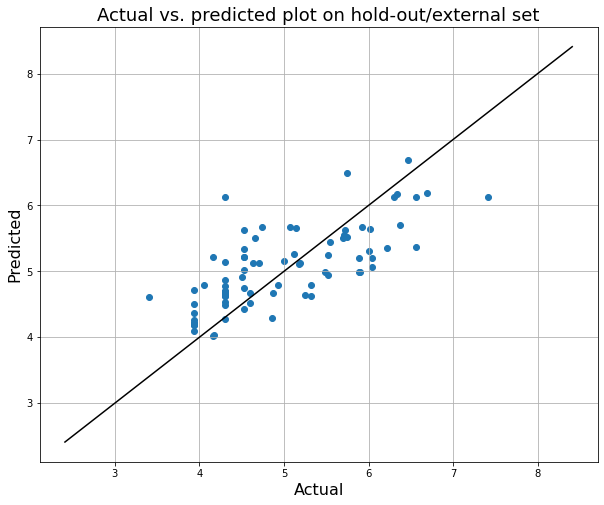

In [24]:
smiles_codes_val = model_wrapper.Data["smiles_codes_val"]
smiles_codes_train = model_wrapper.Data["smiles_codes_train"]
model_wrapper.Pipeline.fit(X=smiles_codes_train, y=None)
X_val = create_molecular_features(pipeline=model_wrapper.Pipeline, smiles_codes=smiles_codes_val)
X_val = process_molecular_features(pipeline=model_wrapper.Pipeline, X=X_val)
y_train_val_pred = model_wrapper.Predict(X_val)
y_train_val = model_wrapper.Data["targets_val"]
plotScatterWithIdeal(y_train_val.values, y_train_val_pred.values, "Actual vs. predicted plot on hold-out/external set")
l.info("R2 score on hold-out/external: %s", r2_score(y_train_val, y_train_val_pred))
l.info("MSE score on hold-out/external: %s", mean_squared_error(y_train_val, y_train_val_pred))
l.info("MAE score on hold-out/external: %s", mean_absolute_error(y_train_val, y_train_val_pred))